In [1]:

import numpy as np
import datetime
import glob
import os
import matplotlib.pyplot as plt
import cartopy
from matplotlib import gridspec
import itertools
import cartopy.crs as ccrs
import tqdm
import netCDF4 as nc 
from scipy.stats import linregress
from pyproj import Proj, Transformer
from scipy.interpolate import griddata
from scipy.odr import ODR, Model, Data, RealData


import warnings
import pickle
warnings.filterwarnings("ignore")


In [11]:
def draw_map(m, scale=0.2):
    # draw a shaded-relief image
    # m.shadedrelief(scale=scale)
    m.drawlsmask(land_color='gray',ocean_color='white',lakes=True)
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')

def mask_observations(observations, inversion):
    new_inversion = np.copy(inversion)
    for i in range(len(observations)):
        for j in range(len(observations[0])):
            if np.isnan(observations[i][j]):
                new_inversion[i][j] = np.nan
    return new_inversion


def mask_high_error(stddev, inversion):
    new_inversion = np.copy(inversion)
    for i in range(len(stddev)):
        for j in range(len(stddev[0])):
            if stddev[i][j] >= inversion[i][j]*(20/100):
                new_inversion[i][j] = np.nan
    return new_inversion


def mask_sie(sie_map, inversion):
    new_inversion = np.copy(inversion)
    for i in range(len(sie_map)):
        for j in range(len(sie_map[0])):
            if not np.isnan(sie_map[i][j]) and sie_map[i][j] < 0.7:
                new_inversion[i][j] = np.nan
    return new_inversion

def model_func(beta, x):
    m, b = beta  # beta contient les paramètres du modèle (pente, ordonnée à l'origine)
    return m * x + b


def pearson(inverse, OIB):
    # pearson coefficient
    ydata = np.array(inverse)
    yfit = np.array(OIB)

    ydata_mean = np.mean(ydata)
    yfit_mean = np.mean(yfit)

    data_diff = ydata - ydata_mean
    fit_diff = yfit - yfit_mean

    top = np.sum( (data_diff) * (fit_diff) )

    bottom = np.sqrt( np.sum(data_diff**2) * np.sum(fit_diff**2) )

    r = top/bottom

    return r

def analyse (calculated_data, validation_data):
    error = np.array(calculated_data) - np.array(validation_data)
    md = np.mean(error)
    rmse = np.sqrt( np.mean( (error)**2 ))
    residuals = error**2
    denom = (calculated_data - np.mean(calculated_data)) ** 2
    r2 = 1 - (np.sum(residuals) / np.sum(denom))

    # Calculate slope and y-intercept
    #slope, intercept = np.polyfit(validation_data, calculated_data, 1)
    data = RealData(validation_data, calculated_data)
    model = Model(model_func)
    beta0 = [1.0, 0.0]
    odr = ODR(data, model, beta0=beta0)
    output = odr.run()

    slope = output.beta[0]
    intercept = output.beta[1]


    return md, rmse, r2, slope, intercept


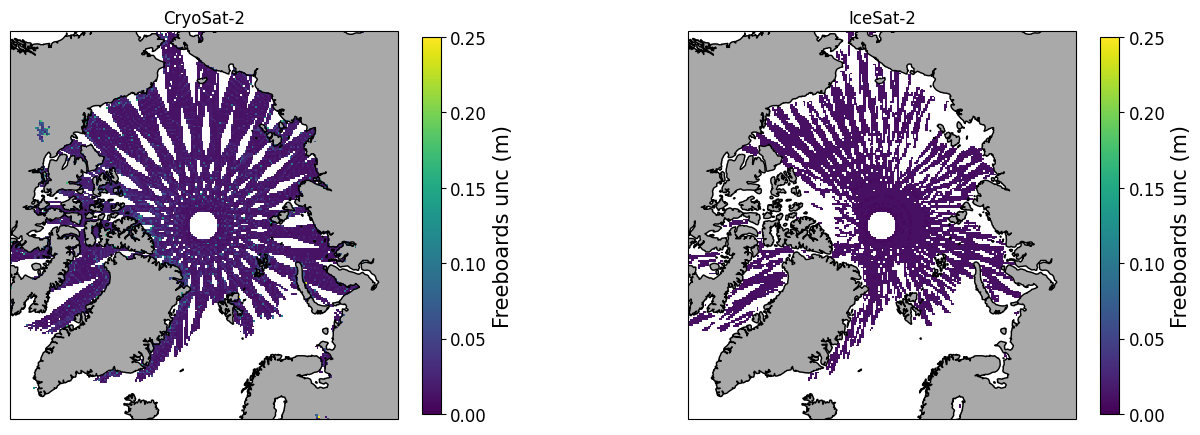

In [26]:
path_IS2 = "/home/erb/masterproject/MSCI_project/snow_ice/carmen/non_interpolated_data/freeboard_daily_processed/IS2/dailyFB_25km_2018-2019_season.pkl"
path_CS2 = "/home/erb/masterproject/MSCI_project/snow_ice/carmen/non_interpolated_data/freeboard_daily_processed/CS2_LARM/dailyFB_25km_2018-2019_season.pkl"

fb_is2_unc = "/home/cjn/michel_inversions/25km_ease_binned/uncertainties/IS2/"
fb_cs2_unc = "/home/cjn/michel_inversions/25km_ease_binned/uncertainties/CS2_LARM/"

f = open(path_IS2,'rb')
IS2_ni = pickle.load(f)

f = open(path_CS2,'rb')
CS2_ni = pickle.load(f)

lon_g = np.load("/home/erb/masterproject/MSCI_project/new_lon_25km.npy")
lat_g = np.load("/home/erb/masterproject/MSCI_project/new_lat_25km.npy")
date     = ["20190408", "20190409", "20190410", "20190411", "20190412", "20190413", "20190414", "20190415", "20190416", 
            "20190417", "20190418", "20190419", "20190420", "20190421", "20190422"]

IS2_ni_carte, CS2_ni_carte = [], []
cs2, is2 = [], []

for i in range(len(date)) :
    IS2_unc = nc.Dataset(fb_is2_unc + date[i] + '.nc')
    CS2_unc = nc.Dataset(fb_cs2_unc + date[i] + '.nc')

    IS2_ni_carte.append(IS2_unc.variables['fb_unc'][:]) 
    CS2_ni_carte.append(CS2_unc.variables['fb_unc'][:]) 
    
    f = open(path_IS2,'rb')
    IS2 = pickle.load(f)


    f = open(path_CS2,'rb')
    CS2 = pickle.load(f)


    is2.append(IS2[date[i]])
    cs2.append(CS2[date[i]])



fig = plt.figure(figsize = (15,7))
spec = gridspec.GridSpec(ncols=2, nrows=1,wspace=0.4)

ax1 = fig.add_subplot(spec[0], projection=ccrs.NorthPolarStereo())
ax1.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=0)
ax1.add_feature(cartopy.feature.OCEAN, color='white', edgecolor='black')
ax1.coastlines()
ax1.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
for i in range(len(CS2_ni_carte)) : 
    p_map = ax1.pcolormesh(lon_g,lat_g, CS2_ni_carte[i],cmap='viridis',alpha=1.0, transform=ccrs.PlateCarree(), vmin = 0, vmax = 0.25)
plt.title('CryoSat-2')
a = fig.colorbar(p_map,shrink=0.7, pad=0.05)
a.ax.tick_params(labelsize=12)
a.set_label('Freeboards unc (m)',fontsize=15)


ax2 = fig.add_subplot(spec[1],projection=ccrs.NorthPolarStereo())
ax2.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=0)
ax2.add_feature(cartopy.feature.OCEAN, color='white', edgecolor='black')
ax2.coastlines()
ax2.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
for i in range(len(IS2_ni_carte)) : 
    p_map = ax2.pcolormesh(lon_g,lat_g, IS2_ni_carte[i],cmap='viridis',alpha=1.0, transform=ccrs.PlateCarree(), vmin = 0, vmax = 0.25)

plt.title("IceSat-2")
a = fig.colorbar(p_map, shrink=0.7, pad=0.05)
a.ax.tick_params(labelsize=12)
a.set_label('Freeboards unc (m)',fontsize=15)



In [28]:
CS2_ni_carte = np.array(CS2_ni_carte)
IS2_ni_carte = np.array(IS2_ni_carte)
CS2_ni_carte = np.array(CS2_ni_carte[~np.isnan(CS2_ni_carte)].tolist())#.flatten()
IS2_ni_carte = np.array(IS2_ni_carte[~np.isnan(IS2_ni_carte)].tolist())#.flatten()


is2 = np.array(is2)
is2 = np.array(is2[~np.isnan(is2)].tolist())#.flatten()
cs2 = np.array(cs2)
cs2 = np.array(cs2[~np.isnan(cs2)].tolist())#.flatten()

ValueError: operands could not be broadcast together with shapes (37512,) (34342,) 

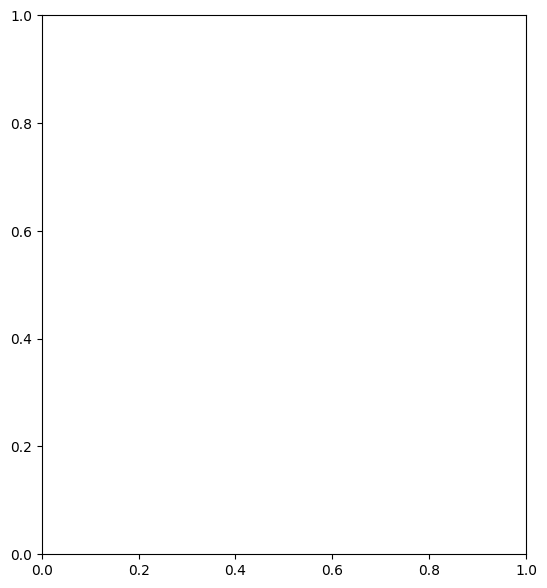

In [29]:
fig = plt.figure(figsize = (15,7))
spec = gridspec.GridSpec(ncols=2, nrows=1,wspace=0.4)

ax1 = fig.add_subplot(spec[0])
ax1.hist(CS2_ni_carte/cs2, bins=30, alpha=0.5, label='CS2')
ax1.set_title('CryoSat-2')
ax1.set_xlabel('FB unc (m)')

ax2 = fig.add_subplot(spec[1])
ax2.hist(IS2_ni_carte/is2, bins=30, alpha=0.5, label='IS2')
ax2.set_title('IceSat-2')
ax2.set_xlabel('FB unc (m)')

## Supplementary figure : Standard deviation for the results of the Figure 1

In [ ]:
# Load inverse SIT CS_IS_2p_LARM

inverseCSIS20182019 = ['/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201811/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs20.75_hierarchicalno_ice_stddev.npy',
                    '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201812/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_ice.npy',
                    '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201901/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_ice.npy',
                    '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201902/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_ice.npy',
                    '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201903/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_ice.npy',
                    '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201904/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs20.75_hierarchicalno_ice_stddev.npy']

inverseCSIS20192020 = ['/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201911/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs20.75_hierarchicalno_ice_stddev.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201912/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_ice.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202001/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_ice.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202002/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_ice.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202003/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_ice.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202004/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs20.75_hierarchicalno_ice_stddev.npy']

inverseCSIS20202021 = ['/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202011/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs20.75_hierarchicalno_ice_stddev.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202012/15tesselationDelaunay_initcell800_iteration2000000_date_window5j_error0.01_ice.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202101/15tesselationDelaunay_initcell800_iteration2000000_date_window5j_error0.01_ice.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202102/15tesselationDelaunay_initcell800_iteration2000000_date_window5j_error0.01_ice.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202103/15tesselationDelaunay_initcell800_iteration2000000_date_window5j_error0.01_ice.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202104/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs20.75_hierarchicalno_ice_stddev.npy']

inverse_CSIS = [inverseCSIS20182019, inverseCSIS20192020, inverseCSIS20202021]


inverseCSAK20182019 = ['/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/201811/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs20.75_hierarchicalno_ice_stddev.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/201812/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/201901/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/201902/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/201903/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/201904/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs20.75_hierarchicalno_ice_stddev.npy']

inverseCSAK20192020 = ['/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/201911/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs20.75_hierarchicalno_ice_stddev.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/201912/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/202001/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/202002/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/202003/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/202004/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs20.75_hierarchicalno_ice_stddev.npy']

inverseCSAK20202021 = ['/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/202011/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs20.75_hierarchicalno_ice_stddev.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/202012/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/202101/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/202102/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/202103/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/202104/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs20.75_hierarchicalno_ice_stddev.npy']

inverse_CSAK = [inverseCSAK20182019, inverseCSAK20192020, inverseCSAK20202021]

In [ ]:
def mask_observations(observations, inversion):
    new_inversion = np.copy(inversion)
    for i in range(len(observations)):
        for j in range(len(observations[0])):
            if np.isnan(observations[i][j]):
                new_inversion[i][j] = np.nan
    return new_inversion


In [ ]:
# Données masqués pour comparer CS_IS et CS_AK
inverse_sit_CSIS_mask = []

for i in range(len(inverse_CSIS)):
    for j in range(len(inverseCSIS20182019)):
        ak = np.load(inverse_CSAK[i][j])
        csis = np.load(inverse_CSIS[i][j])

        csis = mask_observations(ak, csis)

        inverse_sit_CSIS_mask.append(np.nanmean(csis))

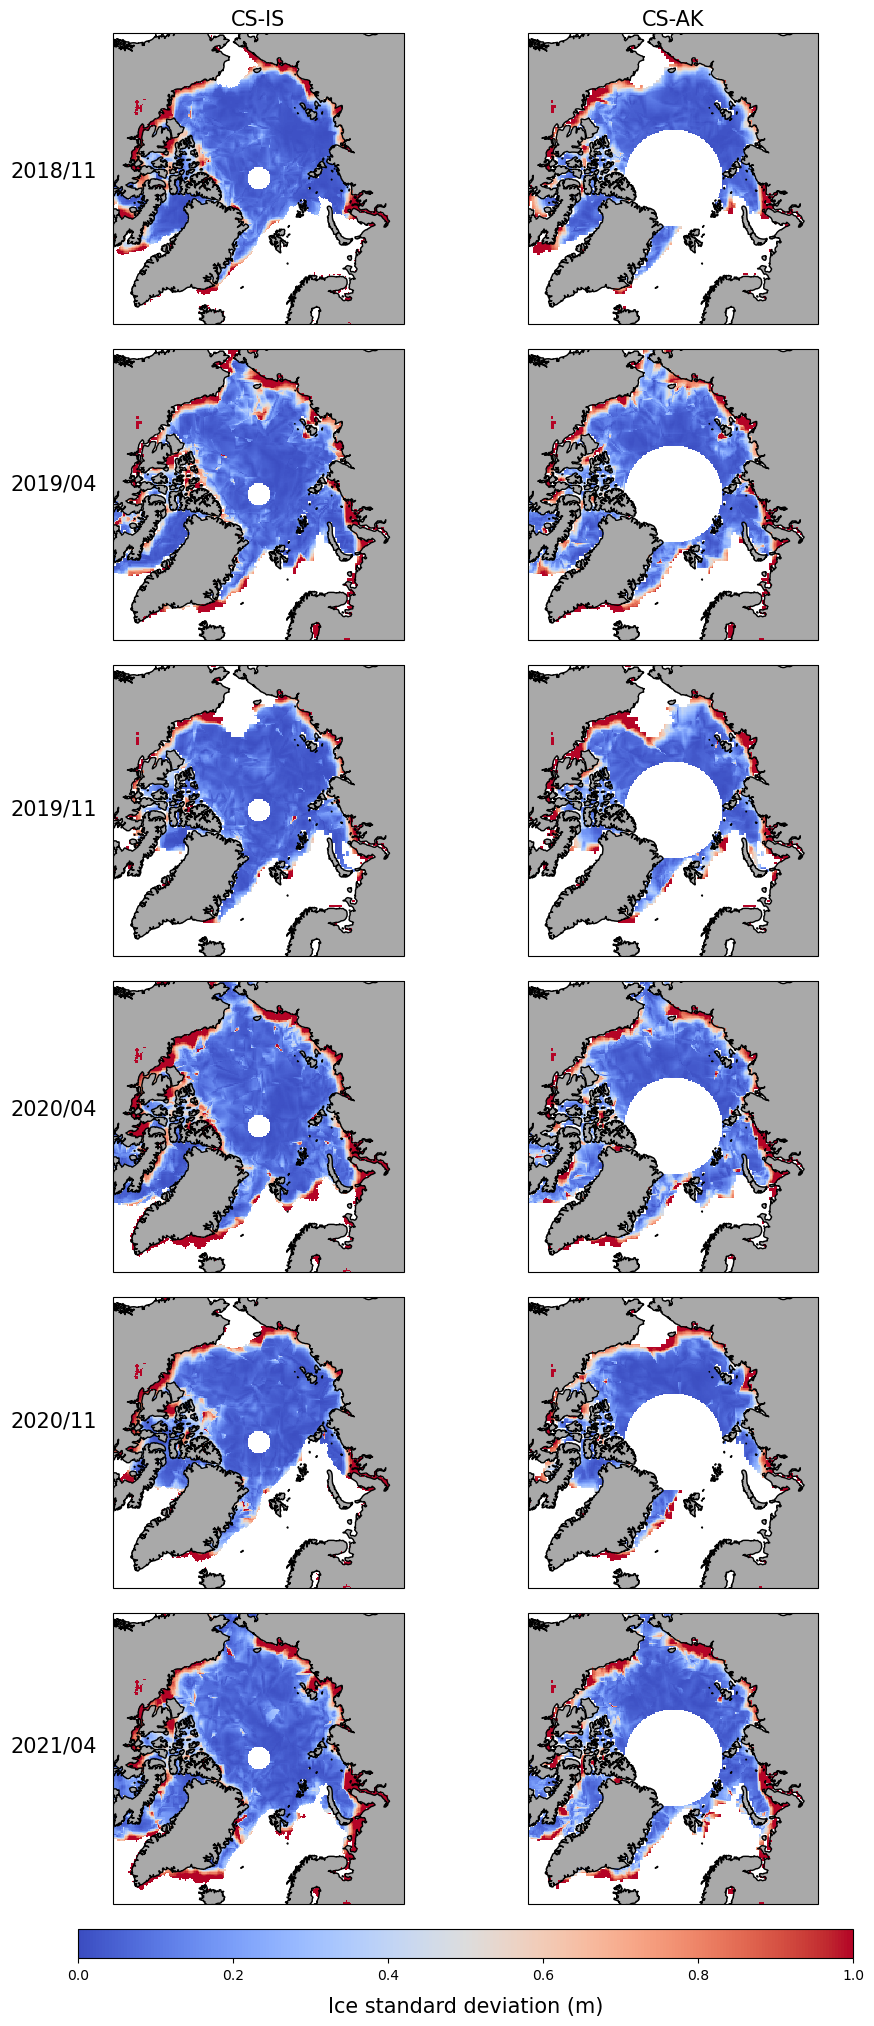

In [ ]:
fig = plt.figure(figsize=(10,25))
spec = gridspec.GridSpec(ncols=2, nrows=7, hspace=0.1, wspace=0.15, height_ratios=[1,1,1, 1, 1, 1, 0.1])


months = ["November 2018", "April 2019", "November 2019", "April 2020", "November 2020", "April 2021"]
date = ['Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr']
lon_g = np.load("/home/erb/masterproject/MSCI_project/new_lon_25km.npy")
lat_g = np.load("/home/erb/masterproject/MSCI_project/new_lat_25km.npy")


inverse_map_CSIS = [np.load(inverseCSIS20182019[0]), np.load(inverseCSIS20182019[5]), np.load(inverseCSIS20192020[0]), 
                    np.load(inverseCSIS20192020[5]), np.load(inverseCSIS20202021[0]), np.load(inverseCSIS20202021[5])]


inverse_map_CSAK = [np.load(inverseCSAK20182019[0]), np.load(inverseCSAK20182019[5]), np.load(inverseCSAK20192020[0]), 
                    np.load(inverseCSAK20192020[5]), np.load(inverseCSAK20202021[0]), np.load(inverseCSAK20202021[5])]


for i in range(6):
    ax = fig.add_subplot(spec[i,0],projection=ccrs.NorthPolarStereo())

    if i == 0: 
        ax.set_title('CS-IS', fontsize = 15)
    ax.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=1)
    ax.coastlines()  
    p_map = ax.pcolormesh(lon_g,lat_g, inverse_map_CSIS[i],cmap='coolwarm',alpha=1.0, transform=ccrs.PlateCarree(), vmin = 0, vmax = 1)


    ax2 = fig.add_subplot(spec[i,1],projection=ccrs.NorthPolarStereo())
    if i == 0:
        ax2.set_title('CS-AK', fontsize = 15)
    ax2.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
    ax2.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=1)
    ax2.coastlines()  
    p_map = ax2.pcolormesh(lon_g,lat_g, inverse_map_CSAK[i],cmap='coolwarm',alpha=1.0, transform=ccrs.PlateCarree(), vmin = 0, vmax = 1)



cax = fig.add_subplot(spec[12:14])
fig.colorbar(p_map, cax =cax, orientation = "horizontal")
cax.xaxis.set_ticks_position('bottom')
cax.set_xlabel('Ice standard deviation (m)', labelpad = 10, fontsize = 15)
cax.xaxis.set_label_position('bottom')



date = ["2018/11", "2019/04","2019/11", "2020/04", "2020/11", "2021/04"]

fig.text(0.1, 0.825, date[0], va='center', ha='center', fontsize=15)
fig.text(0.1, 0.7, date[1], va='center', ha='center', fontsize=15)
fig.text(0.1, 0.57, date[2], va='center', ha='center', fontsize=15)
fig.text(0.1, 0.45, date[3], va='center', ha='center', fontsize=15)
fig.text(0.1, 0.325, date[4], va='center', ha='center', fontsize=15)
fig.text(0.1, 0.195, date[5], va='center', ha='center', fontsize=15)

save_fig = 0
if save_fig == 1 :
    plt.savefig('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/figures/timeseries_stddev.png', dpi = 300)



## Supplementary figure : Figure 1 with alpha_cs = 1

In [ ]:
# Load inverse SIT CS_IS_2p_LARM

inverseCSIS20182019 = ['/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201811/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs21_hierarchicalno_ice.npy',
                    '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201812/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_ice.npy',
                    '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201901/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_ice.npy',
                    '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201902/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_ice.npy',
                    '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201903/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_ice.npy',
                    '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201904/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs21_hierarchicalno_ice.npy']

inverseCSIS20192020 = ['/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201911/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs21_hierarchicalno_ice.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201912/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_ice.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202001/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_ice.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202002/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_ice.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202003/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_ice.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202004/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs21_hierarchicalno_ice.npy']

inverseCSIS20202021 = ['/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202011/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs21_hierarchicalno_ice.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202012/15tesselationDelaunay_initcell800_iteration2000000_date_window5j_error0.01_ice.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202101/15tesselationDelaunay_initcell800_iteration2000000_date_window5j_error0.01_ice.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202102/15tesselationDelaunay_initcell800_iteration2000000_date_window5j_error0.01_ice.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202103/15tesselationDelaunay_initcell800_iteration2000000_date_window5j_error0.01_ice.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202104/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs21_hierarchicalno_ice.npy']

inverse_CSIS = [inverseCSIS20182019, inverseCSIS20192020, inverseCSIS20202021]


inverseCSAK20182019 = ['/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/201811/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs20.75_hierarchicalno_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/201812/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/201901/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/201902/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/201903/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/201904/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs20.75_hierarchicalno_ice.npy']

inverseCSAK20192020 = ['/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/201911/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs20.75_hierarchicalno_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/201912/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/202001/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/202002/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/202003/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/202004/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs20.75_hierarchicalno_ice.npy']

inverseCSAK20202021 = ['/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/202011/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs20.75_hierarchicalno_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/202012/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/202101/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/202102/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/202103/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/202104/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs20.75_hierarchicalno_ice.npy']

inverse_CSAK = [inverseCSAK20182019, inverseCSAK20192020, inverseCSAK20202021]

In [ ]:
def mask_observations(observations, inversion):
    new_inversion = np.copy(inversion)
    for i in range(len(observations)):
        for j in range(len(observations[0])):
            if np.isnan(observations[i][j]):
                new_inversion[i][j] = np.nan
    return new_inversion


In [ ]:
# Données masqués pour comparer CS_IS et CS_AK
inverse_sit_CSIS_mask = []

for i in range(len(inverse_CSIS)):
    for j in range(len(inverseCSIS20182019)):
        ak = np.load(inverse_CSAK[i][j])
        csis = np.load(inverse_CSIS[i][j])

        csis = mask_observations(ak, csis)

        inverse_sit_CSIS_mask.append(np.nanmean(csis))

In [ ]:
# Données Awismos

awismos_20182019 = ['/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2018/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-201811-fv2p4.nc',
                    '/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2018/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-201812-fv2p4.nc',
                    '/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2019/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-201901-fv2p4.nc',
                    '/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2019/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-201902-fv2p4.nc',
                    '/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2019/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-201903-fv2p4.nc',
                    '/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2019/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-201904-fv2p4.nc']

awismos_20192020 = ['/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2019/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-201911-fv2p4.nc',
                    '/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2019/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-201912-fv2p4.nc',
                    '/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2020/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-202001-fv2p4.nc',
                    '/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2020/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-202002-fv2p4.nc',
                    '/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2020/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-202003-fv2p4.nc',
                    '/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2020/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-202004-fv2p4.nc']

awismos_20202021 = ['/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2020/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-202011-fv2p4.nc',
                    '/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2020/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-202012-fv2p4.nc',
                    '/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2021/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-202101-fv2p4.nc',
                    '/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2021/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-202102-fv2p4.nc',
                    '/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2021/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-202103-fv2p4.nc',
                    '/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2021/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-202104-fv2p4.nc']

awismos= [awismos_20182019, awismos_20192020, awismos_20202021]

awismos_sit = []

for i in range(len(awismos)):
    for j in range(len(awismos_20182019)):
        sit = nc.Dataset(awismos[i][j]).variables['sea_ice_thickness'][0][36:396,36:396][::-1, :]

        awismos_sit.append(np.nanmean(sit))
    


In [ ]:
awismos_map_sit = []

for i in range(len(awismos)):
    for j in range(len(awismos_20182019)):
        awismos_map_sit.append(nc.Dataset(awismos[i][j]).variables['sea_ice_thickness'][0][36:396,36:396][::-1, :])

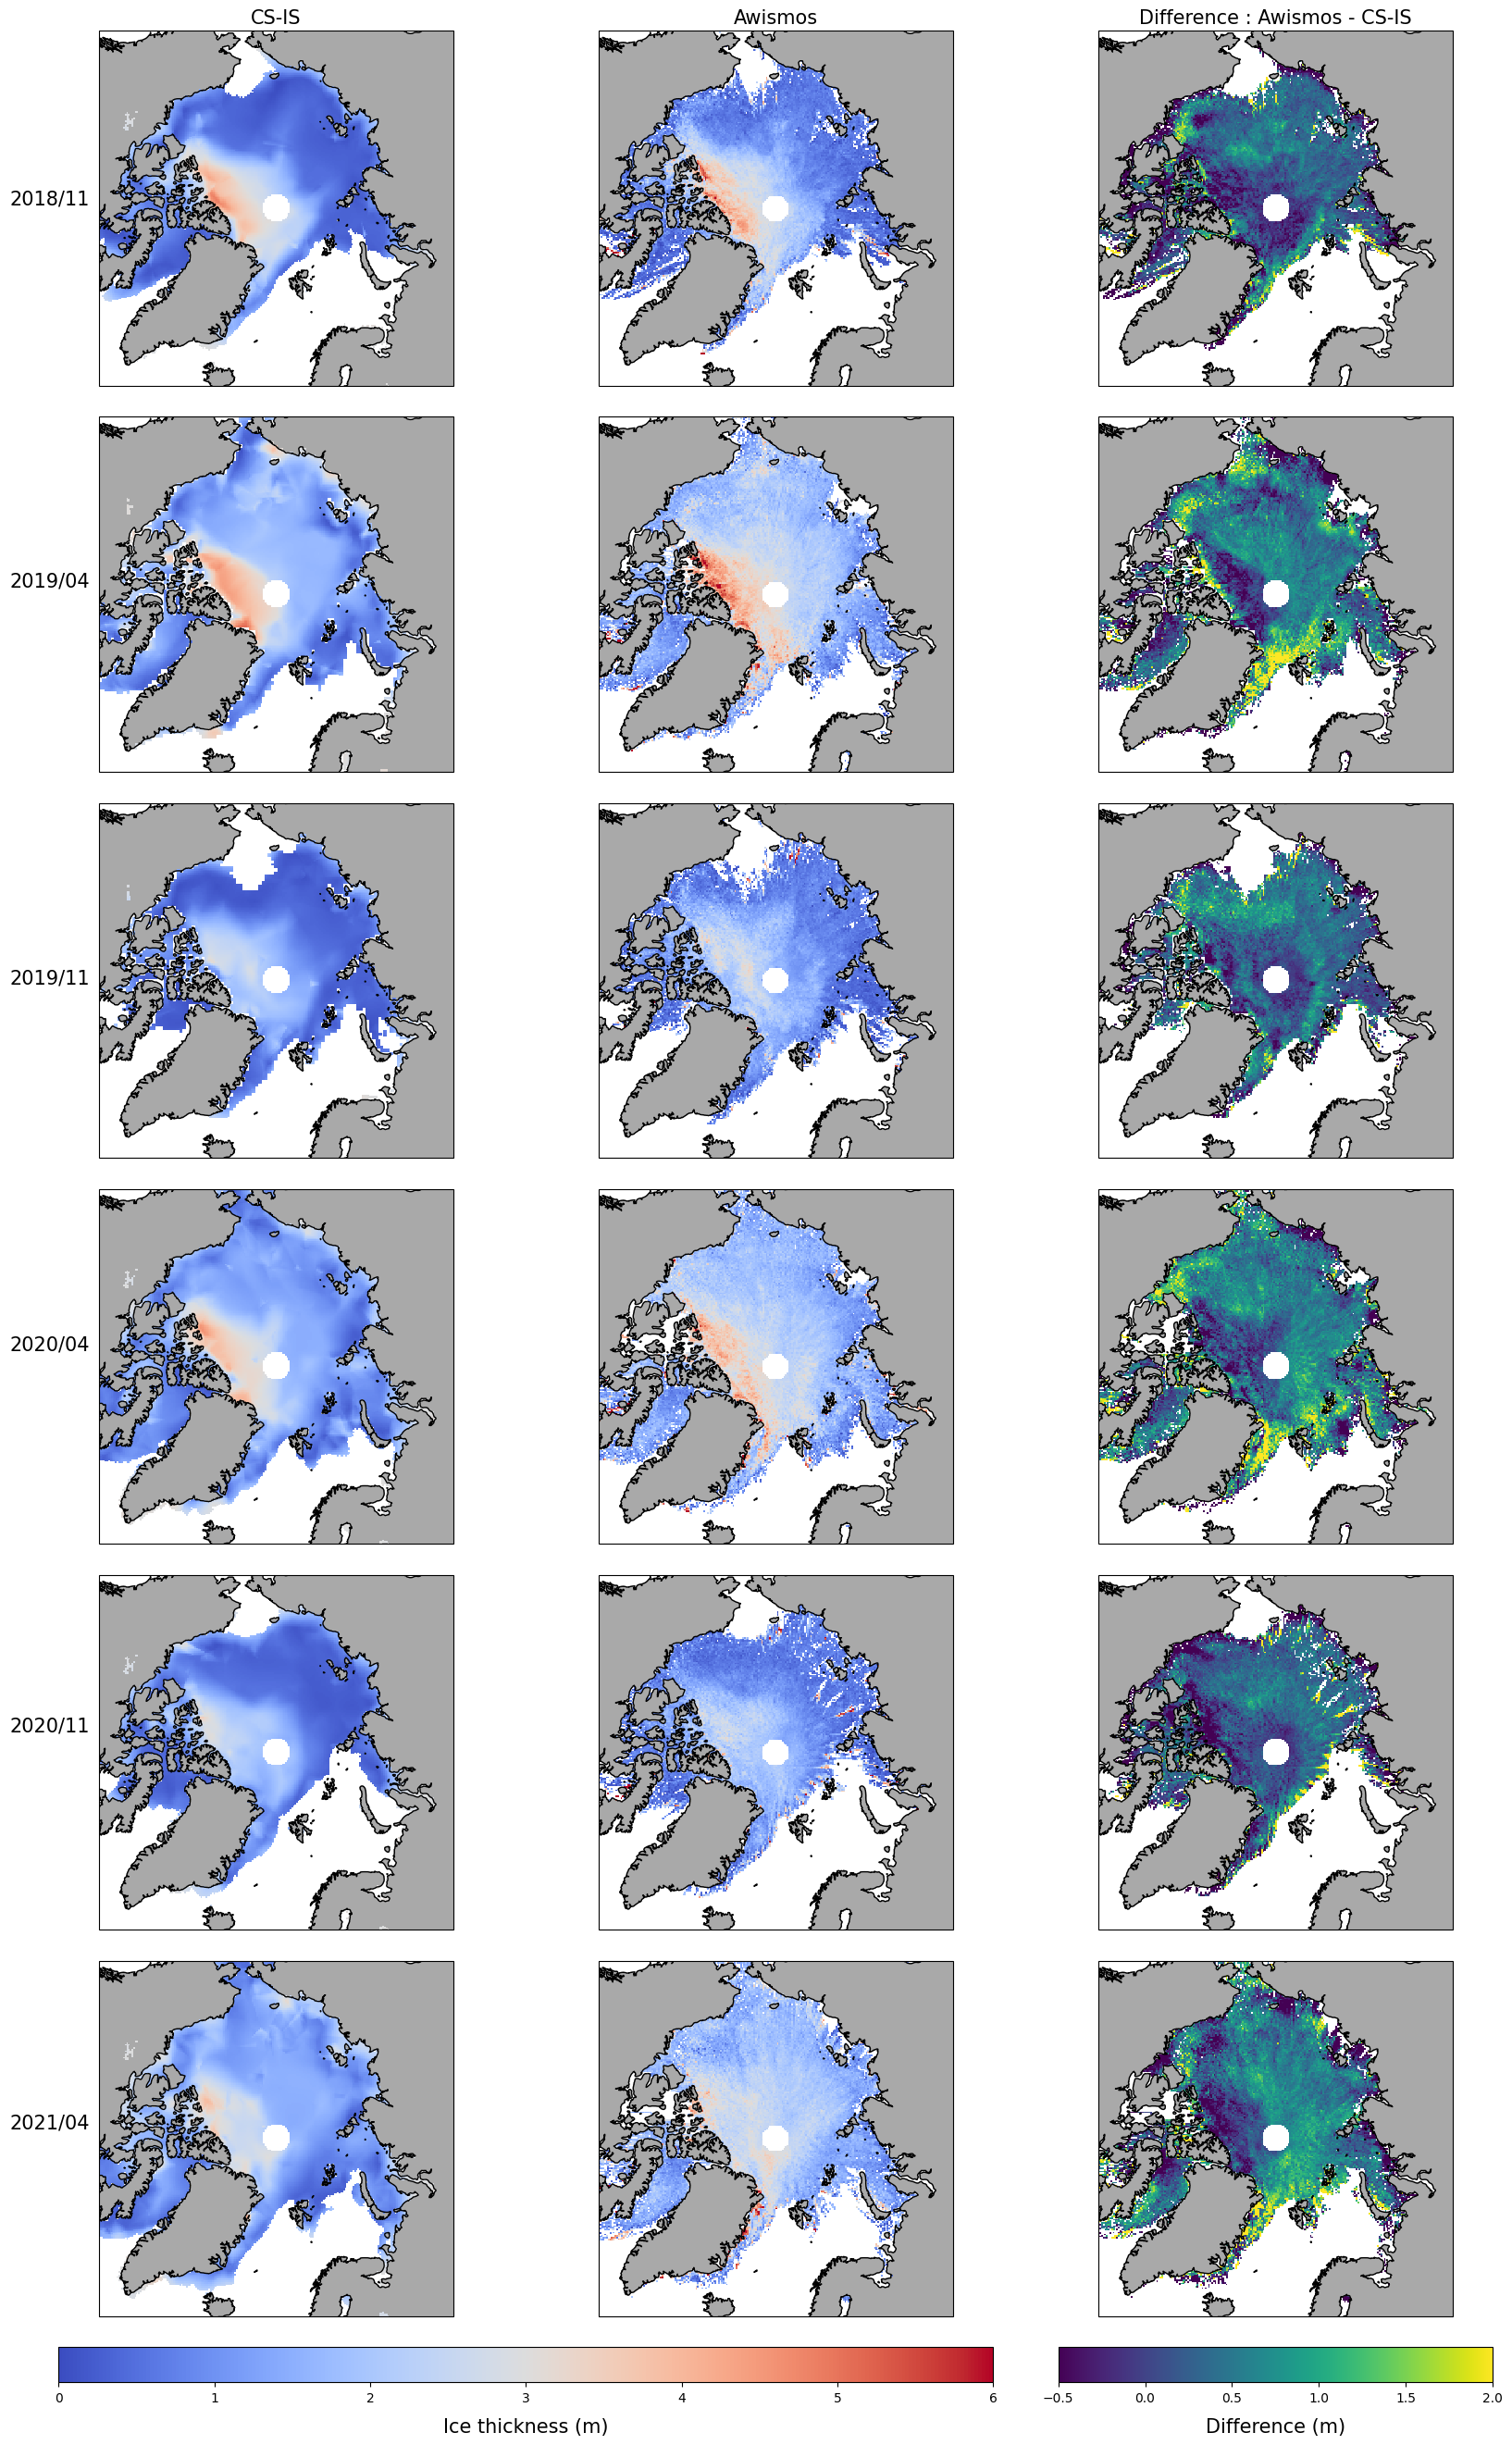

In [ ]:
fig = plt.figure(figsize=(20,33))
spec = gridspec.GridSpec(ncols=3, nrows=7, hspace=0.1, wspace=0.15, height_ratios=[1,1,1, 1, 1, 1, 0.1])


months = ["November 2018", "April 2019", "November 2019", "April 2020", "November 2020", "April 2021"]
date = ['Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr']
lon_g = np.load("/home/erb/masterproject/MSCI_project/new_lon_25km.npy")
lat_g = np.load("/home/erb/masterproject/MSCI_project/new_lat_25km.npy")


inverse_map_CSIS = [np.load(inverseCSIS20182019[0]), np.load(inverseCSIS20182019[5]), np.load(inverseCSIS20192020[0]), 
                    np.load(inverseCSIS20192020[5]), np.load(inverseCSIS20202021[0]), np.load(inverseCSIS20202021[5])]


awismos_map      = [awismos_map_sit[0], awismos_map_sit[5], awismos_map_sit[6], awismos_map_sit[11],
                    awismos_map_sit[12], awismos_map_sit[17]]


for i in range(6):
    ax = fig.add_subplot(spec[i,0],projection=ccrs.NorthPolarStereo())

    if i == 0: 
        ax.set_title('CS-IS', fontsize = 15)
    ax.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=1)
    ax.coastlines()  
    p_map = ax.pcolormesh(lon_g,lat_g, inverse_map_CSIS[i],cmap='coolwarm',alpha=1.0, transform=ccrs.PlateCarree(), vmin = 0, vmax = 6)



    ax3 = fig.add_subplot(spec[i,1], projection = ccrs.NorthPolarStereo())
    if i == 0:
        ax3.set_title('Awismos', fontsize = 15)
    ax3.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
    ax3.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=1)
    ax3.coastlines()  
    p_map = ax3.pcolormesh(lon_g,lat_g, awismos_map[i] ,cmap='coolwarm',alpha=1.0, transform=ccrs.PlateCarree(), vmin = 0, vmax = 6)

    ax3 = fig.add_subplot(spec[i,2], projection = ccrs.NorthPolarStereo())
    if i == 0:
        ax3.set_title('Difference : Awismos - CS-IS', fontsize = 15)
    ax3.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
    ax3.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=1)
    ax3.coastlines()  
    p_map_diff = ax3.pcolormesh(lon_g,lat_g, awismos_map[i] - inverse_map_CSIS[i] ,cmap='viridis',alpha=1.0, transform=ccrs.PlateCarree(), vmin = -0.5, vmax = 2)


cax = fig.add_subplot(spec[18:20])
fig.colorbar(p_map, cax =cax, orientation = "horizontal")
cax.xaxis.set_ticks_position('bottom')
cax.set_xlabel('Ice thickness (m)', labelpad = 10, fontsize = 15)
cax.xaxis.set_label_position('bottom')


cax = fig.add_subplot(spec[20])
fig.colorbar(p_map_diff, cax =cax, orientation = "horizontal")
cax.xaxis.set_ticks_position('bottom')
cax.set_xlabel('Difference (m)', labelpad = 10, fontsize = 15)
cax.xaxis.set_label_position('bottom')


date = ["2018/11", "2019/04","2019/11", "2020/04", "2020/11", "2021/04"]

fig.text(0.12, 0.825, date[0], va='center', ha='center', fontsize=15)
fig.text(0.12, 0.7, date[1], va='center', ha='center', fontsize=15)
fig.text(0.12, 0.57, date[2], va='center', ha='center', fontsize=15)
fig.text(0.12, 0.45, date[3], va='center', ha='center', fontsize=15)
fig.text(0.12, 0.325, date[4], va='center', ha='center', fontsize=15)
fig.text(0.12, 0.195, date[5], va='center', ha='center', fontsize=15)

save_fig = 1
if save_fig == 1 :
    plt.savefig('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/figures/timeseries_awismos_alphacs2=1.png', dpi = 300)



## Supplementary figure : Figure 3 with alpha_cs = 1

In [ ]:
def mask_observations(observations, inversion):
    new_inversion = np.copy(inversion)
    for i in range(len(observations)):
        for j in range(len(observations[0])):
            if np.isnan(observations[i][j]):
                new_inversion[i][j] = np.nan
    return new_inversion

def lonlat_to_xy(coords_1, coords_2, hemisphere, inverse=False):

    """Converts between longitude/latitude and EASE xy coordinates.
 
    Args:
        lon (float): WGS84 longitude
        lat (float): WGS84 latitude
        hemisphere (string): 'n' or 's'
        inverse (bool): if true, converts xy to lon/lat
 
    Returns:
        tuple: pair of xy or lon/lat values
    """

    EASE_Proj = {'n': 'EPSG:3408',
                 's': 'EPGS:3409'}
    
    WGS_Proj = 'EPSG:4326'
    
    #for coords in [coords_1, coords_2]: assert isinstance(coords,(np.ndarray,list))

    if inverse == False: # lonlat to xy
        
        lon, lat = coords_1, coords_2
        
        transformer = Transformer.from_crs(WGS_Proj, EASE_Proj[hemisphere])
        
        x, y = transformer.transform(lat, lon)
        
        return (x, y)

    else: # xy to lonlat
        
        x, y = coords_1, coords_2
        
        transformer = Transformer.from_crs(EASE_Proj[hemisphere], WGS_Proj)
        
        lat, lon = transformer.transform(x, y)
        
        return (lon, lat)

In [ ]:
# Load inverse SIT CS_IS_2p_LARM

inverseCSIS20182019 = ['/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201811/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs21_hierarchicalno_snow.npy',
                    '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201812/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_ice.npy',
                    '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201901/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_ice.npy',
                    '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201902/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_ice.npy',
                    '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201903/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_ice.npy',
                    '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201904/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs21_hierarchicalno_snow.npy']

inverseCSIS20192020 = ['/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201911/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs21_hierarchicalno_snow.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201912/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_ice.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202001/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_ice.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202002/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_ice.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202003/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_ice.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202004/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs21_hierarchicalno_snow.npy']

inverseCSIS20202021 = ['/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202011/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs21_hierarchicalno_snow.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202012/15tesselationDelaunay_initcell800_iteration2000000_date_window5j_error0.01_ice.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202101/15tesselationDelaunay_initcell800_iteration2000000_date_window5j_error0.01_ice.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202102/15tesselationDelaunay_initcell800_iteration2000000_date_window5j_error0.01_ice.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202103/15tesselationDelaunay_initcell800_iteration2000000_date_window5j_error0.01_ice.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202104/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs21_hierarchicalno_snow.npy']

inverse_CSIS = [inverseCSIS20182019, inverseCSIS20192020, inverseCSIS20202021]

In [ ]:
lon_g = np.load("/home/erb/masterproject/MSCI_project/new_lon_25km.npy")
lat_g = np.load("/home/erb/masterproject/MSCI_project/new_lat_25km.npy")

IS2 = [np.load("/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/IS2/FB_interp_2018_25km_20181115.npy"),
        np.load("/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/IS2/FB_interp_2019_25km_20190415.npy"),
        np.load("/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/IS2/FB_interp_2019_25km_20191115.npy"),
        np.load("/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/IS2/FB_interp_2020_25km_20200415.npy"),
        np.load("/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/IS2/FB_interp_2020_25km_20201115.npy"),
        np.load("/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/IS2/FB_interp_2021_25km_20210415.npy")]


amsr2_snow_files = ['/home/erb/masterproject/MSCI_project/validation_data/AMSR2_data/mpr_retrieval_amsr_20181115_ease_25_v0.2.nc',
                    '/home/erb/masterproject/MSCI_project/validation_data/AMSR2_data/mpr_retrieval_amsr_20190415_ease_25_v0.2.nc',
                    '/home/erb/masterproject/MSCI_project/validation_data/AMSR2_data/mpr_retrieval_amsr_20191115_ease_25_v0.2.nc',
                    '/home/erb/masterproject/MSCI_project/validation_data/AMSR2_data/mpr_retrieval_amsr_20200415_ease_25_v0.2.nc',
                    '/home/erb/masterproject/MSCI_project/validation_data/AMSR2_data/mpr_retrieval_amsr_20201115_ease_25_v0.2.nc',
                    '/home/erb/masterproject/MSCI_project/validation_data/AMSR2_data/mpr_retrieval_amsr_20210415_ease_25_v0.2.nc']

    # fpath = '/home/cn/Sentinel3Snod/DATA/Bremen_snow/2019/03/snowdepth_amsr2_20190315v1.1.nc'



import xarray as xr

def get_pm_bremen_snow_lonlats():
    fpath = '/home/erb/masterproject/MSCI_project/validation_data/AMSR2/mpr_retrieval_amsr_20181115_ease_25_v0.2.nc'
    ds = xr.open_dataset(fpath)
    return ds['lon'].values, ds['lat'].values

def get_pm_bremen_snow_values(fpath):
    # fpath = '/home/cn/Sentinel3Snod/DATA/Bremen_snow/2019/03/snowdepth_amsr2_20190315v1.1.nc'
    ds = xr.open_dataset(fpath)
    return ds['snd'].values



lon_AMSR2, lat_AMSR2 = get_pm_bremen_snow_lonlats()
# snow_AMSR2, snow_unc_AMSR2 = get_pm_bremen_snow_values()

x_AMSR2, y_AMSR2 = lonlat_to_xy(lon_AMSR2, lat_AMSR2, "n", inverse=False)

lon_g = np.load("/home/erb/masterproject/MSCI_project/new_lon_25km.npy")
lat_g = np.load("/home/erb/masterproject/MSCI_project/new_lat_25km.npy")

x_EASE2, y_EASE2 = lonlat_to_xy(lon_g, lat_g, "n", inverse=False)


def snow_amsr2(path_awismos):

    snow_AMSR2 = get_pm_bremen_snow_values(path_awismos)
    snow_AMSR2_EASE2 = griddata((x_AMSR2.ravel(), y_AMSR2.ravel()), snow_AMSR2.ravel(), (x_EASE2, y_EASE2), method='nearest')
    #snow_AMSR2_EASE2 = snow_AMSR2_EASE2/100.
    snow_AMSR2_EASE2 = snow_AMSR2_EASE2
    return snow_AMSR2_EASE2

def inverse_snow(inverse_snow_files, path_awismos):
    snow_inverse, ST_amsr2 = [], []

    snow_AMSR2 = get_pm_bremen_snow_values(path_awismos)
    snow_AMSR2_EASE2 = griddata((x_AMSR2.ravel(), y_AMSR2.ravel()), snow_AMSR2.ravel(), (x_EASE2, y_EASE2), method='nearest')
    #snow_AMSR2_EASE2 = snow_AMSR2_EASE2/100.
    snow_AMSR2_EASE2 = snow_AMSR2_EASE2
    
    snow_inverse_data = np.load(inverse_snow_files)

    for k in range(360):
        for j in range(360):
        #if not SIT_awismos.mask[k][j] and not np.isnan(ice_inverse_data[k][j]):
            if not np.isnan(snow_inverse_data[k][j]) and not np.isnan(snow_AMSR2_EASE2[k][j]):
                snow_inverse.append(snow_inverse_data[k][j])
                ST_amsr2.append(snow_AMSR2_EASE2[k][j])
    
    return snow_inverse, ST_amsr2

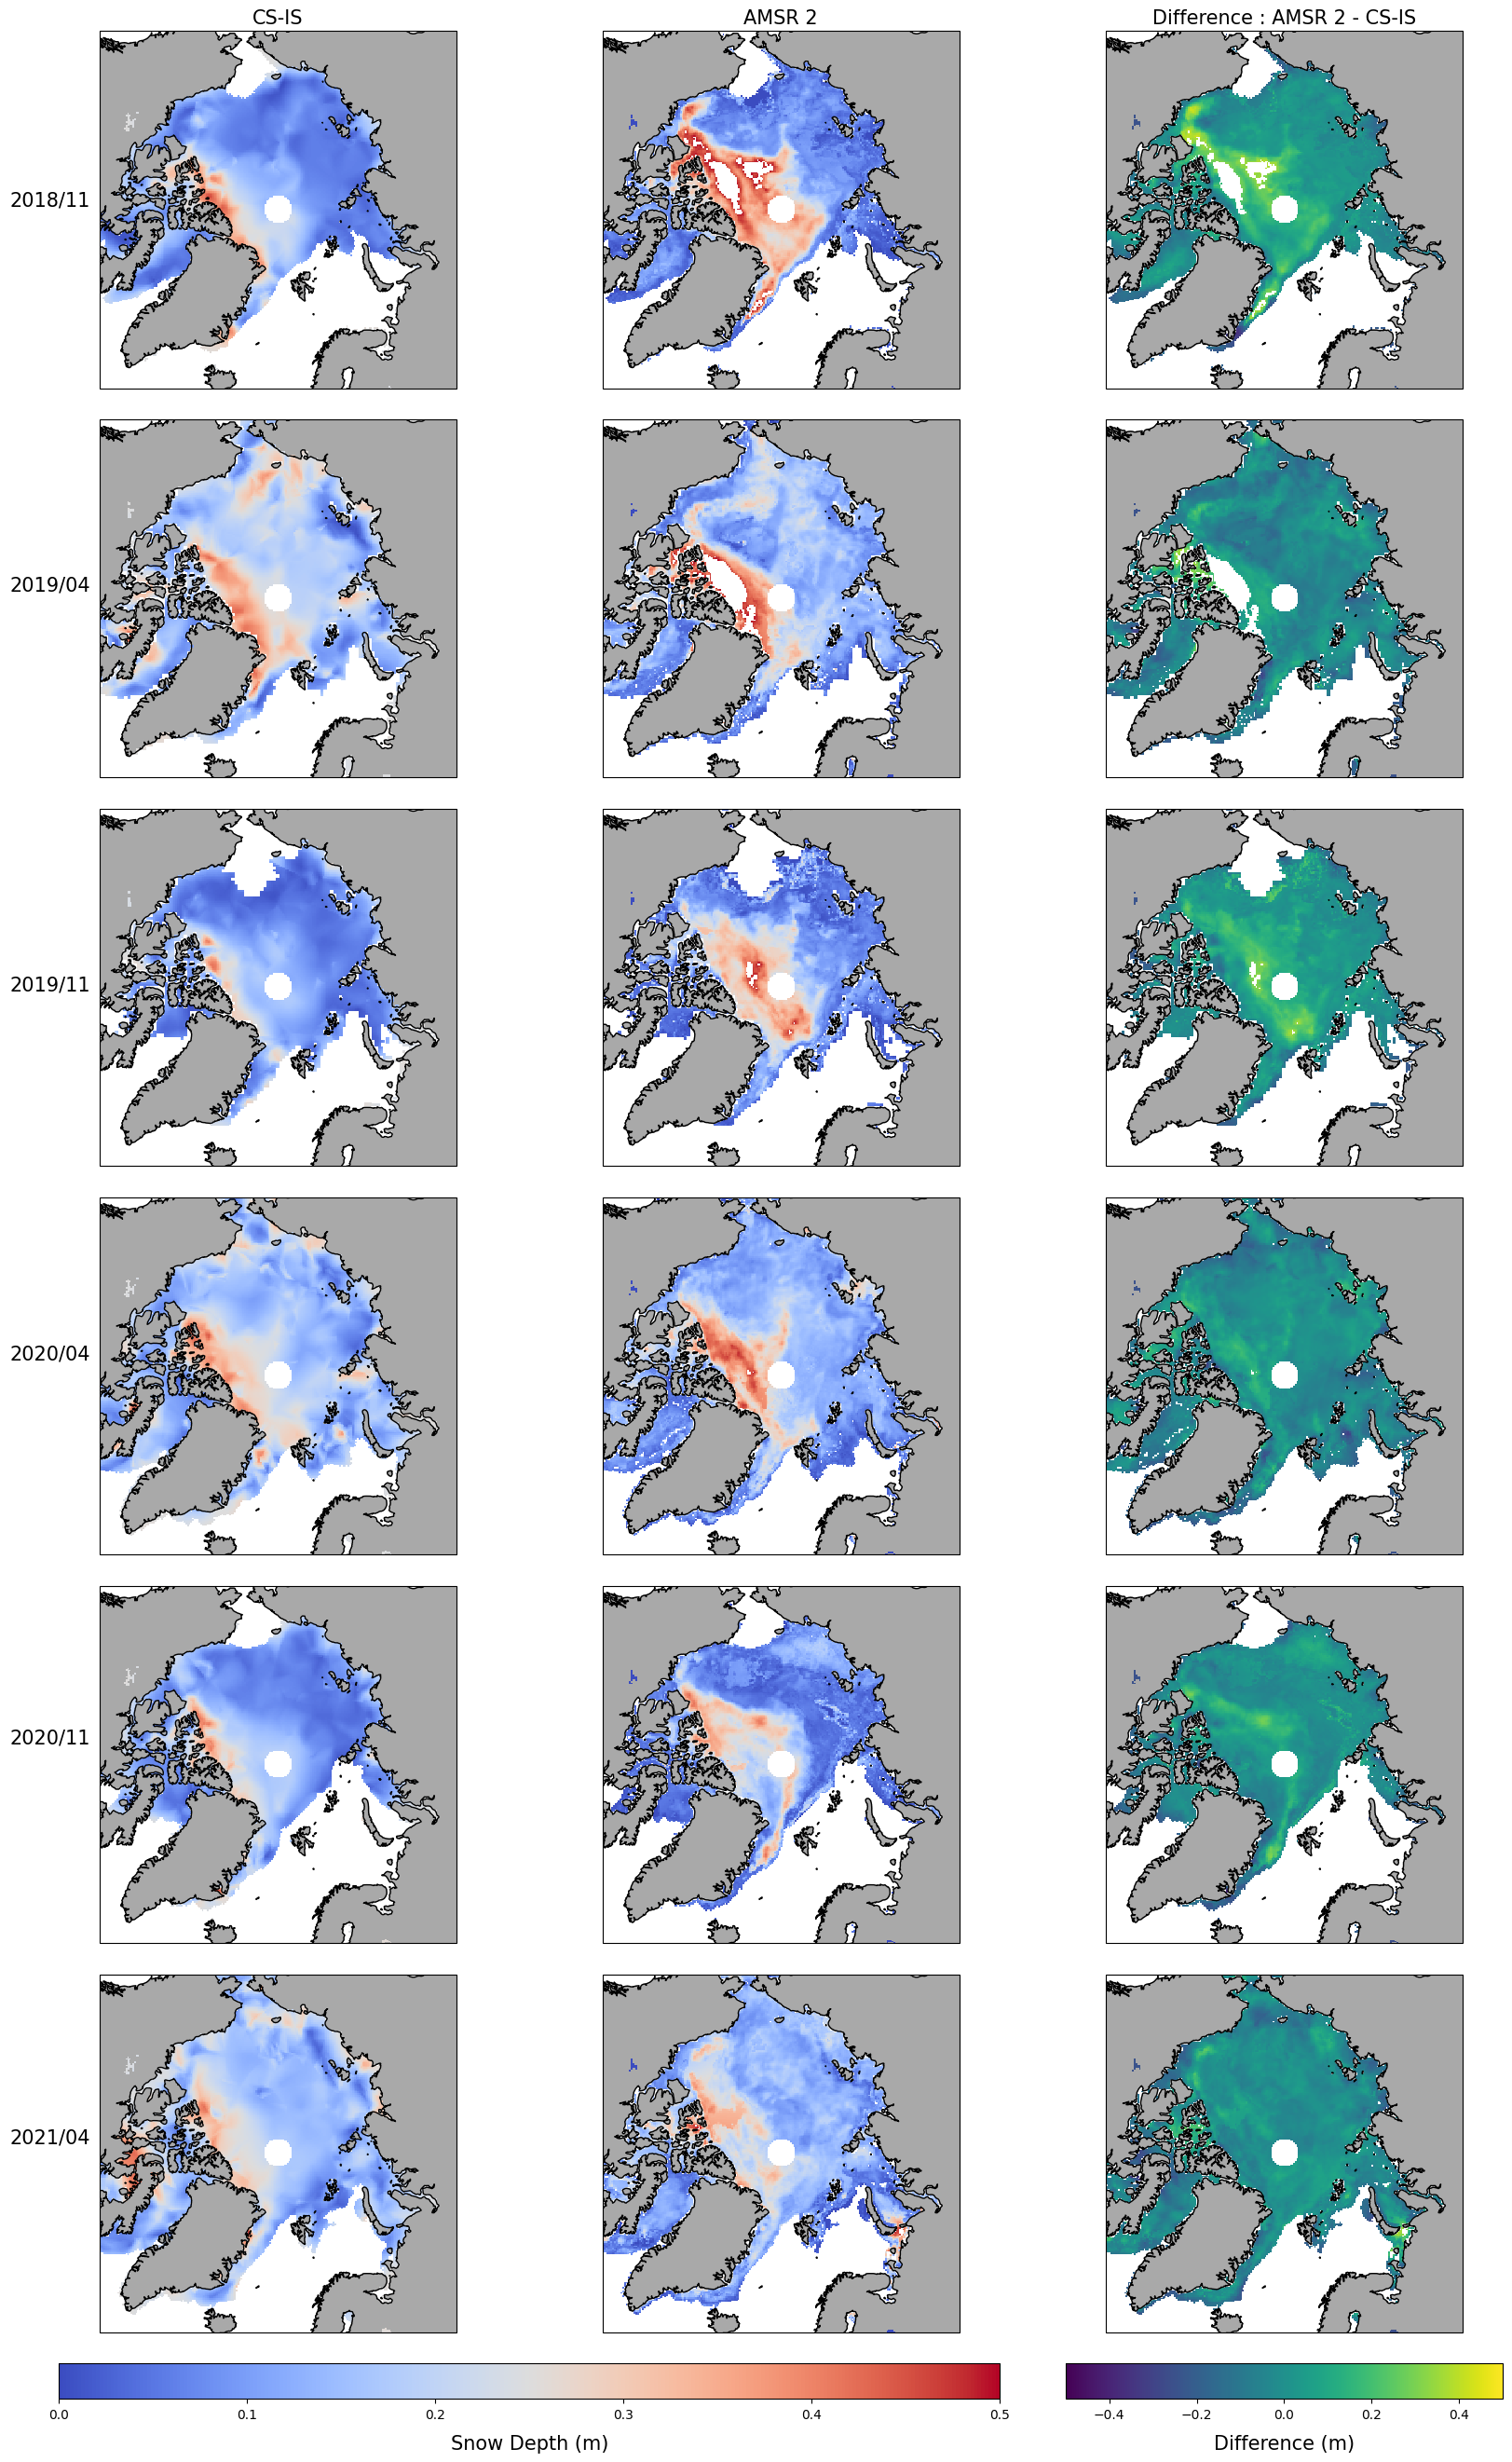

In [ ]:
fig = plt.figure(figsize=(20,33))
spec = gridspec.GridSpec(ncols=3, nrows=7, hspace=0.1, wspace=0.15, height_ratios=[1,1,1, 1, 1, 1, 0.1])


months = ["November 2018", "April 2019", "November 2019", "April 2020", "November 2020", "April 2021"]
date = ['Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr']
lon_g = np.load("/home/erb/masterproject/MSCI_project/new_lon_25km.npy")
lat_g = np.load("/home/erb/masterproject/MSCI_project/new_lat_25km.npy")


inverse_map_CSIS = [np.load(inverseCSIS20182019[0]), np.load(inverseCSIS20182019[5]), np.load(inverseCSIS20192020[0]), 
                    np.load(inverseCSIS20192020[5]), np.load(inverseCSIS20202021[0]), np.load(inverseCSIS20202021[5])]



for i in range(6):
    ax = fig.add_subplot(spec[i,0],projection=ccrs.NorthPolarStereo())

    if i == 0: 
        ax.set_title('CS-IS', fontsize = 15)
    ax.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=1)
    ax.coastlines()  
    p_map = ax.pcolormesh(lon_g,lat_g, inverse_map_CSIS[i],cmap='coolwarm',alpha=1.0, transform=ccrs.PlateCarree(), vmin = 0, vmax = 0.5)


    ax3 = fig.add_subplot(spec[i,1], projection = ccrs.NorthPolarStereo())
    if i == 0:
        ax3.set_title('AMSR 2', fontsize = 15)
    ax3.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
    ax3.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=1)
    ax3.coastlines()  
    p_map = ax3.pcolormesh(lon_g,lat_g, mask_observations(IS2[i],snow_amsr2(amsr2_snow_files[i])) ,cmap='coolwarm',alpha=1.0, transform=ccrs.PlateCarree(), vmin = 0, vmax = 0.5)

    ax3 = fig.add_subplot(spec[i,2], projection = ccrs.NorthPolarStereo())
    if i == 0:
        ax3.set_title('Difference : AMSR 2 - CS-IS', fontsize = 15)
    ax3.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
    ax3.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=1)
    ax3.coastlines()  
    p_map_diff = ax3.pcolormesh(lon_g,lat_g, mask_observations(IS2[i],snow_amsr2(amsr2_snow_files[i])) - inverse_map_CSIS[i] ,cmap='viridis',alpha=1.0, transform=ccrs.PlateCarree(), vmin = -0.5, vmax = 0.5)


cax = fig.add_subplot(spec[18:20])
fig.colorbar(p_map, cax =cax, orientation = "horizontal")
cax.xaxis.set_ticks_position('bottom')
cax.set_xlabel('Snow Depth (m)', labelpad = 10, fontsize = 15)
cax.xaxis.set_label_position('bottom')


cax = fig.add_subplot(spec[20])
fig.colorbar(p_map_diff, cax =cax, orientation = "horizontal")
cax.xaxis.set_ticks_position('bottom')
cax.set_xlabel('Difference (m)', labelpad = 10, fontsize = 15)
cax.xaxis.set_label_position('bottom')


date = ["2018/11", "2019/04","2019/11", "2020/04", "2020/11", "2021/04"]

fig.text(0.12, 0.825, date[0], va='center', ha='center', fontsize=15)
fig.text(0.12, 0.7, date[1], va='center', ha='center', fontsize=15)
fig.text(0.12, 0.57, date[2], va='center', ha='center', fontsize=15)
fig.text(0.12, 0.45, date[3], va='center', ha='center', fontsize=15)
fig.text(0.12, 0.325, date[4], va='center', ha='center', fontsize=15)
fig.text(0.12, 0.195, date[5], va='center', ha='center', fontsize=15)

save_fig = 1
if save_fig == 1 :
    plt.savefig('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/figures/timeseries_amsr_alphacs=1.png', dpi = 300)



## Result for the mass

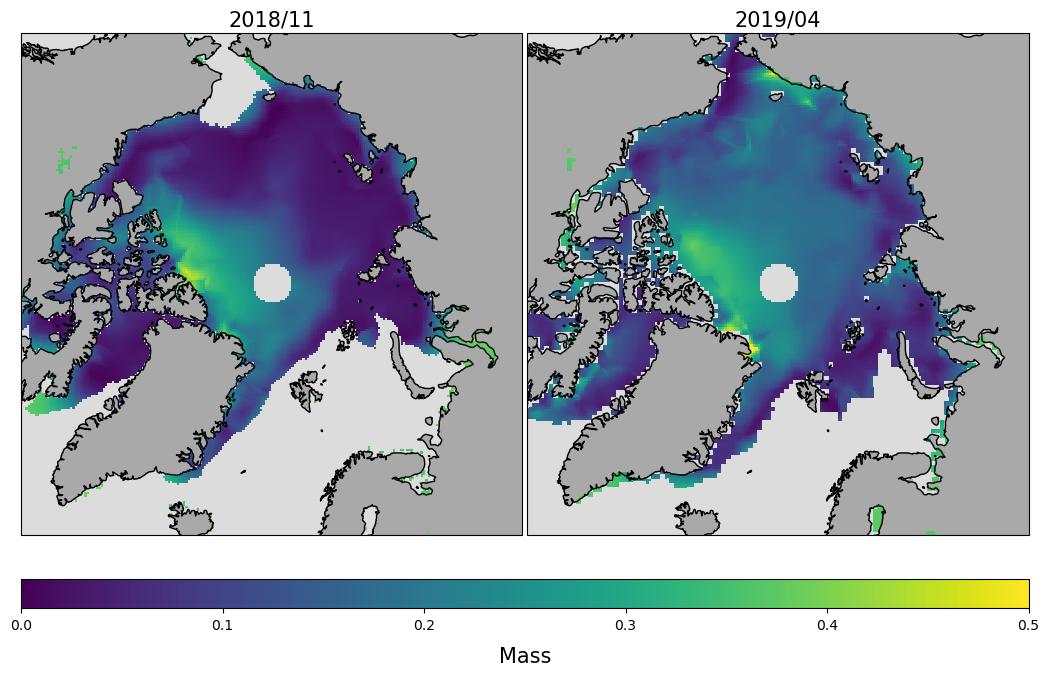

In [9]:
mass_file = ['/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201811/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs20.75_hierarchicalno_mass.npy',
            '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201904/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs20.75_hierarchicalno_mass.npy']

lon_g = np.load("/home/erb/masterproject/MSCI_project/new_lon_25km.npy")
lat_g = np.load("/home/erb/masterproject/MSCI_project/new_lat_25km.npy")


fig = plt.figure(figsize = (13,8))
spec = gridspec.GridSpec(ncols=2, nrows=2,wspace=0.01, hspace=0.01, height_ratios=[1, 0.05])

ax1 = fig.add_subplot(spec[0], projection=ccrs.NorthPolarStereo())
ax1.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=0)
ax1.add_feature(cartopy.feature.OCEAN, color='gainsboro', edgecolor='black')
ax1.coastlines()
ax1.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
ax1.set_title('2018/11', fontsize = 15)
p_map_snow = ax1.pcolormesh(lon_g,lat_g, np.load(mass_file[0]),cmap='viridis',alpha=1.0, transform=ccrs.PlateCarree(), vmin = 0, vmax = 0.5)

ax2 = fig.add_subplot(spec[1],projection=ccrs.NorthPolarStereo())
ax2.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=0)
ax2.add_feature(cartopy.feature.OCEAN, color='gainsboro', edgecolor='black')
ax2.coastlines()
ax2.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
ax2.set_title('2019/04', fontsize = 15)
p_map_ice= ax2.pcolormesh(lon_g,lat_g, np.load(mass_file[1]),cmap='viridis',alpha=1.0, transform=ccrs.PlateCarree(), vmin = 0, vmax = 0.5)



cax = fig.add_subplot(spec[2:4])
fig.colorbar(p_map_snow, cax =cax, orientation = "horizontal")
cax.xaxis.set_ticks_position('bottom')
cax.set_xlabel('Mass', labelpad = 10, fontsize = 15)
cax.xaxis.set_label_position('bottom')

save_fig = 1
if save_fig == 1 :
    plt.savefig('/home/erb/masterproject/MSCI_project/snow_ice/figures_paper/figures/map_2018-2019_mass.png', dpi = 300)

        

## PDF and scatter plot for Fig 1 and 2

In [3]:
# Load inverse SIT CS_IS_2p_LARM

inverseCSIS20182019 = ['/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201811/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs21_hierarchicalno_ice.npy',
                    '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201812/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_ice.npy',
                    '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201901/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_ice.npy',
                    '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201902/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_ice.npy',
                    '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201903/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_ice.npy',
                    '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201904/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs21_hierarchicalno_ice.npy']

inverseCSIS20192020 = ['/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201911/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs21_hierarchicalno_ice.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201912/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_ice.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202001/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_ice.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202002/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_ice.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202003/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_ice.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202004/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs21_hierarchicalno_ice.npy']

inverseCSIS20202021 = ['/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202011/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs21_hierarchicalno_ice.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202012/15tesselationDelaunay_initcell800_iteration2000000_date_window5j_error0.01_ice.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202101/15tesselationDelaunay_initcell800_iteration2000000_date_window5j_error0.01_ice.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202102/15tesselationDelaunay_initcell800_iteration2000000_date_window5j_error0.01_ice.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202103/15tesselationDelaunay_initcell800_iteration2000000_date_window5j_error0.01_ice.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202104/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs21_hierarchicalno_ice.npy']

inverse_CSIS = [inverseCSIS20182019, inverseCSIS20192020, inverseCSIS20202021]


inverseCSAK20182019 = ['/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/201811/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_errorinput_icedensitymixte_alphacs21_hierarchicalno_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/201812/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/201901/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/201902/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/201903/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/201904/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_errorinput_icedensitymixte_alphacs21_hierarchicalno_ice.npy']

inverseCSAK20192020 = ['/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/201911/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_errorinput_icedensitymixte_alphacs21_hierarchicalno_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/201912/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/202001/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/202002/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/202003/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/202004/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_errorinput_icedensitymixte_alphacs21_hierarchicalno_ice.npy']

inverseCSAK20202021 = ['/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/202011/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_errorinput_icedensitymixte_alphacs21_hierarchicalno_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/202012/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/202101/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/202102/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/202103/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/202104/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_errorinput_icedensitymixte_alphacs21_hierarchicalno_ice.npy']

inverse_CSAK = [inverseCSAK20182019, inverseCSAK20192020, inverseCSAK20202021]

# Données AWI

awi_20182019 = ['/home/erb/masterproject/MSCI_project/validation_data/AWI/2.6_AWI_data/2018/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-201811-fv2p6.nc',
                    '/home/erb/masterproject/MSCI_project/validation_data/AWI/2.6_AWI_data/2018/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-201812-fv2p6.nc',
                    '/home/erb/masterproject/MSCI_project/validation_data/AWI/2.6_AWI_data/2019/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-201901-fv2p6.nc',
                    '/home/erb/masterproject/MSCI_project/validation_data/AWI/2.6_AWI_data/2019/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-201902-fv2p6.nc',
                    '/home/erb/masterproject/MSCI_project/validation_data/AWI/2.6_AWI_data/2019/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-201903-fv2p6.nc',
                    '/home/erb/masterproject/MSCI_project/validation_data/AWI/2.6_AWI_data/2019/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-201904-fv2p6.nc']

awi_20192020 = ['/home/erb/masterproject/MSCI_project/validation_data/AWI/2.6_AWI_data/2019/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-201911-fv2p6.nc',
                    '/home/erb/masterproject/MSCI_project/validation_data/AWI/2.6_AWI_data/2019/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-201912-fv2p6.nc',
                    '/home/erb/masterproject/MSCI_project/validation_data/AWI/2.6_AWI_data/2020/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-202001-fv2p6.nc',
                    '/home/erb/masterproject/MSCI_project/validation_data/AWI/2.6_AWI_data/2020/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-202002-fv2p6.nc',
                    '/home/erb/masterproject/MSCI_project/validation_data/AWI/2.6_AWI_data/2020/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-202003-fv2p6.nc',
                    '/home/erb/masterproject/MSCI_project/validation_data/AWI/2.6_AWI_data/2020/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-202004-fv2p6.nc']

awi_20202021 = ['/home/erb/masterproject/MSCI_project/validation_data/AWI/2.6_AWI_data/2020/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-202011-fv2p6.nc',
                    '/home/erb/masterproject/MSCI_project/validation_data/AWI/2.6_AWI_data/2020/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-202012-fv2p6.nc',
                    '/home/erb/masterproject/MSCI_project/validation_data/AWI/2.6_AWI_data/2021/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-202101-fv2p6.nc',
                    '/home/erb/masterproject/MSCI_project/validation_data/AWI/2.6_AWI_data/2021/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-202102-fv2p6.nc',
                    '/home/erb/masterproject/MSCI_project/validation_data/AWI/2.6_AWI_data/2021/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-202103-fv2p6.nc',
                    '/home/erb/masterproject/MSCI_project/validation_data/AWI/2.6_AWI_data/2021/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-202104-fv2p6.nc']

awi= [awi_20182019, awi_20192020, awi_20202021]

awi_sit = []

for i in range(len(awi)):
    for j in range(len(awi_20182019)):
        sit = nc.Dataset(awi[i][j]).variables['sea_ice_thickness'][0][36:396,36:396][::-1, :]

        awi_sit.append(np.nanmean(sit))
    


In [4]:
def mask_observations(observations, inversion):
    new_inversion = np.copy(inversion)
    for i in range(len(observations)):
        for j in range(len(observations[0])):
            if np.isnan(observations[i][j]):
                new_inversion[i][j] = np.nan
    return new_inversion

# Données masqués pour comparer CS_IS et CS_AK
inverse_sit_CSIS_mask = []

for i in range(len(inverse_CSIS)):
    for j in range(len(inverseCSIS20182019)):
        ak = np.load(inverse_CSAK[i][j])
        csis = np.load(inverse_CSIS[i][j])

        csis = mask_observations(ak, csis)

        inverse_sit_CSIS_mask.append(np.nanmean(csis))

awi_map_sit = []

for i in range(len(awi)):
    for j in range(len(awi_20182019)):
        awi_map_sit.append(nc.Dataset(awi[i][j]).variables['sea_ice_thickness'][0][36:396,36:396][::-1, :])


In [5]:
def model_func(beta, x):
    m, b = beta  # beta contient les paramètres du modèle (pente, ordonnée à l'origine)
    return m * x + b


def pearson(inverse, OIB):
    # pearson coefficient
    ydata = np.array(inverse)
    yfit = np.array(OIB)

    ydata_mean = np.mean(ydata)
    yfit_mean = np.mean(yfit)

    data_diff = ydata - ydata_mean
    fit_diff = yfit - yfit_mean

    top = np.sum( (data_diff) * (fit_diff) )

    bottom = np.sqrt( np.sum(data_diff**2) * np.sum(fit_diff**2) )

    r = top/bottom

    return r

def analyse (calculated_data, validation_data):
    error = np.array(calculated_data) - np.array(validation_data)
    md = np.mean(error)
    rmse = np.sqrt( np.mean( (error)**2 ))
    residuals = error**2
    denom = (calculated_data - np.mean(calculated_data)) ** 2
    r2 = 1 - (np.sum(residuals) / np.sum(denom))

    # Calculate slope and y-intercept
    #slope, intercept = np.polyfit(validation_data, calculated_data, 1)
    data = RealData(validation_data, calculated_data)
    model = Model(model_func)
    beta0 = [1.0, 0.0]
    odr = ODR(data, model, beta0=beta0)
    output = odr.run()

    slope = output.beta[0]
    intercept = output.beta[1]


    return md, rmse, r2, slope, intercept


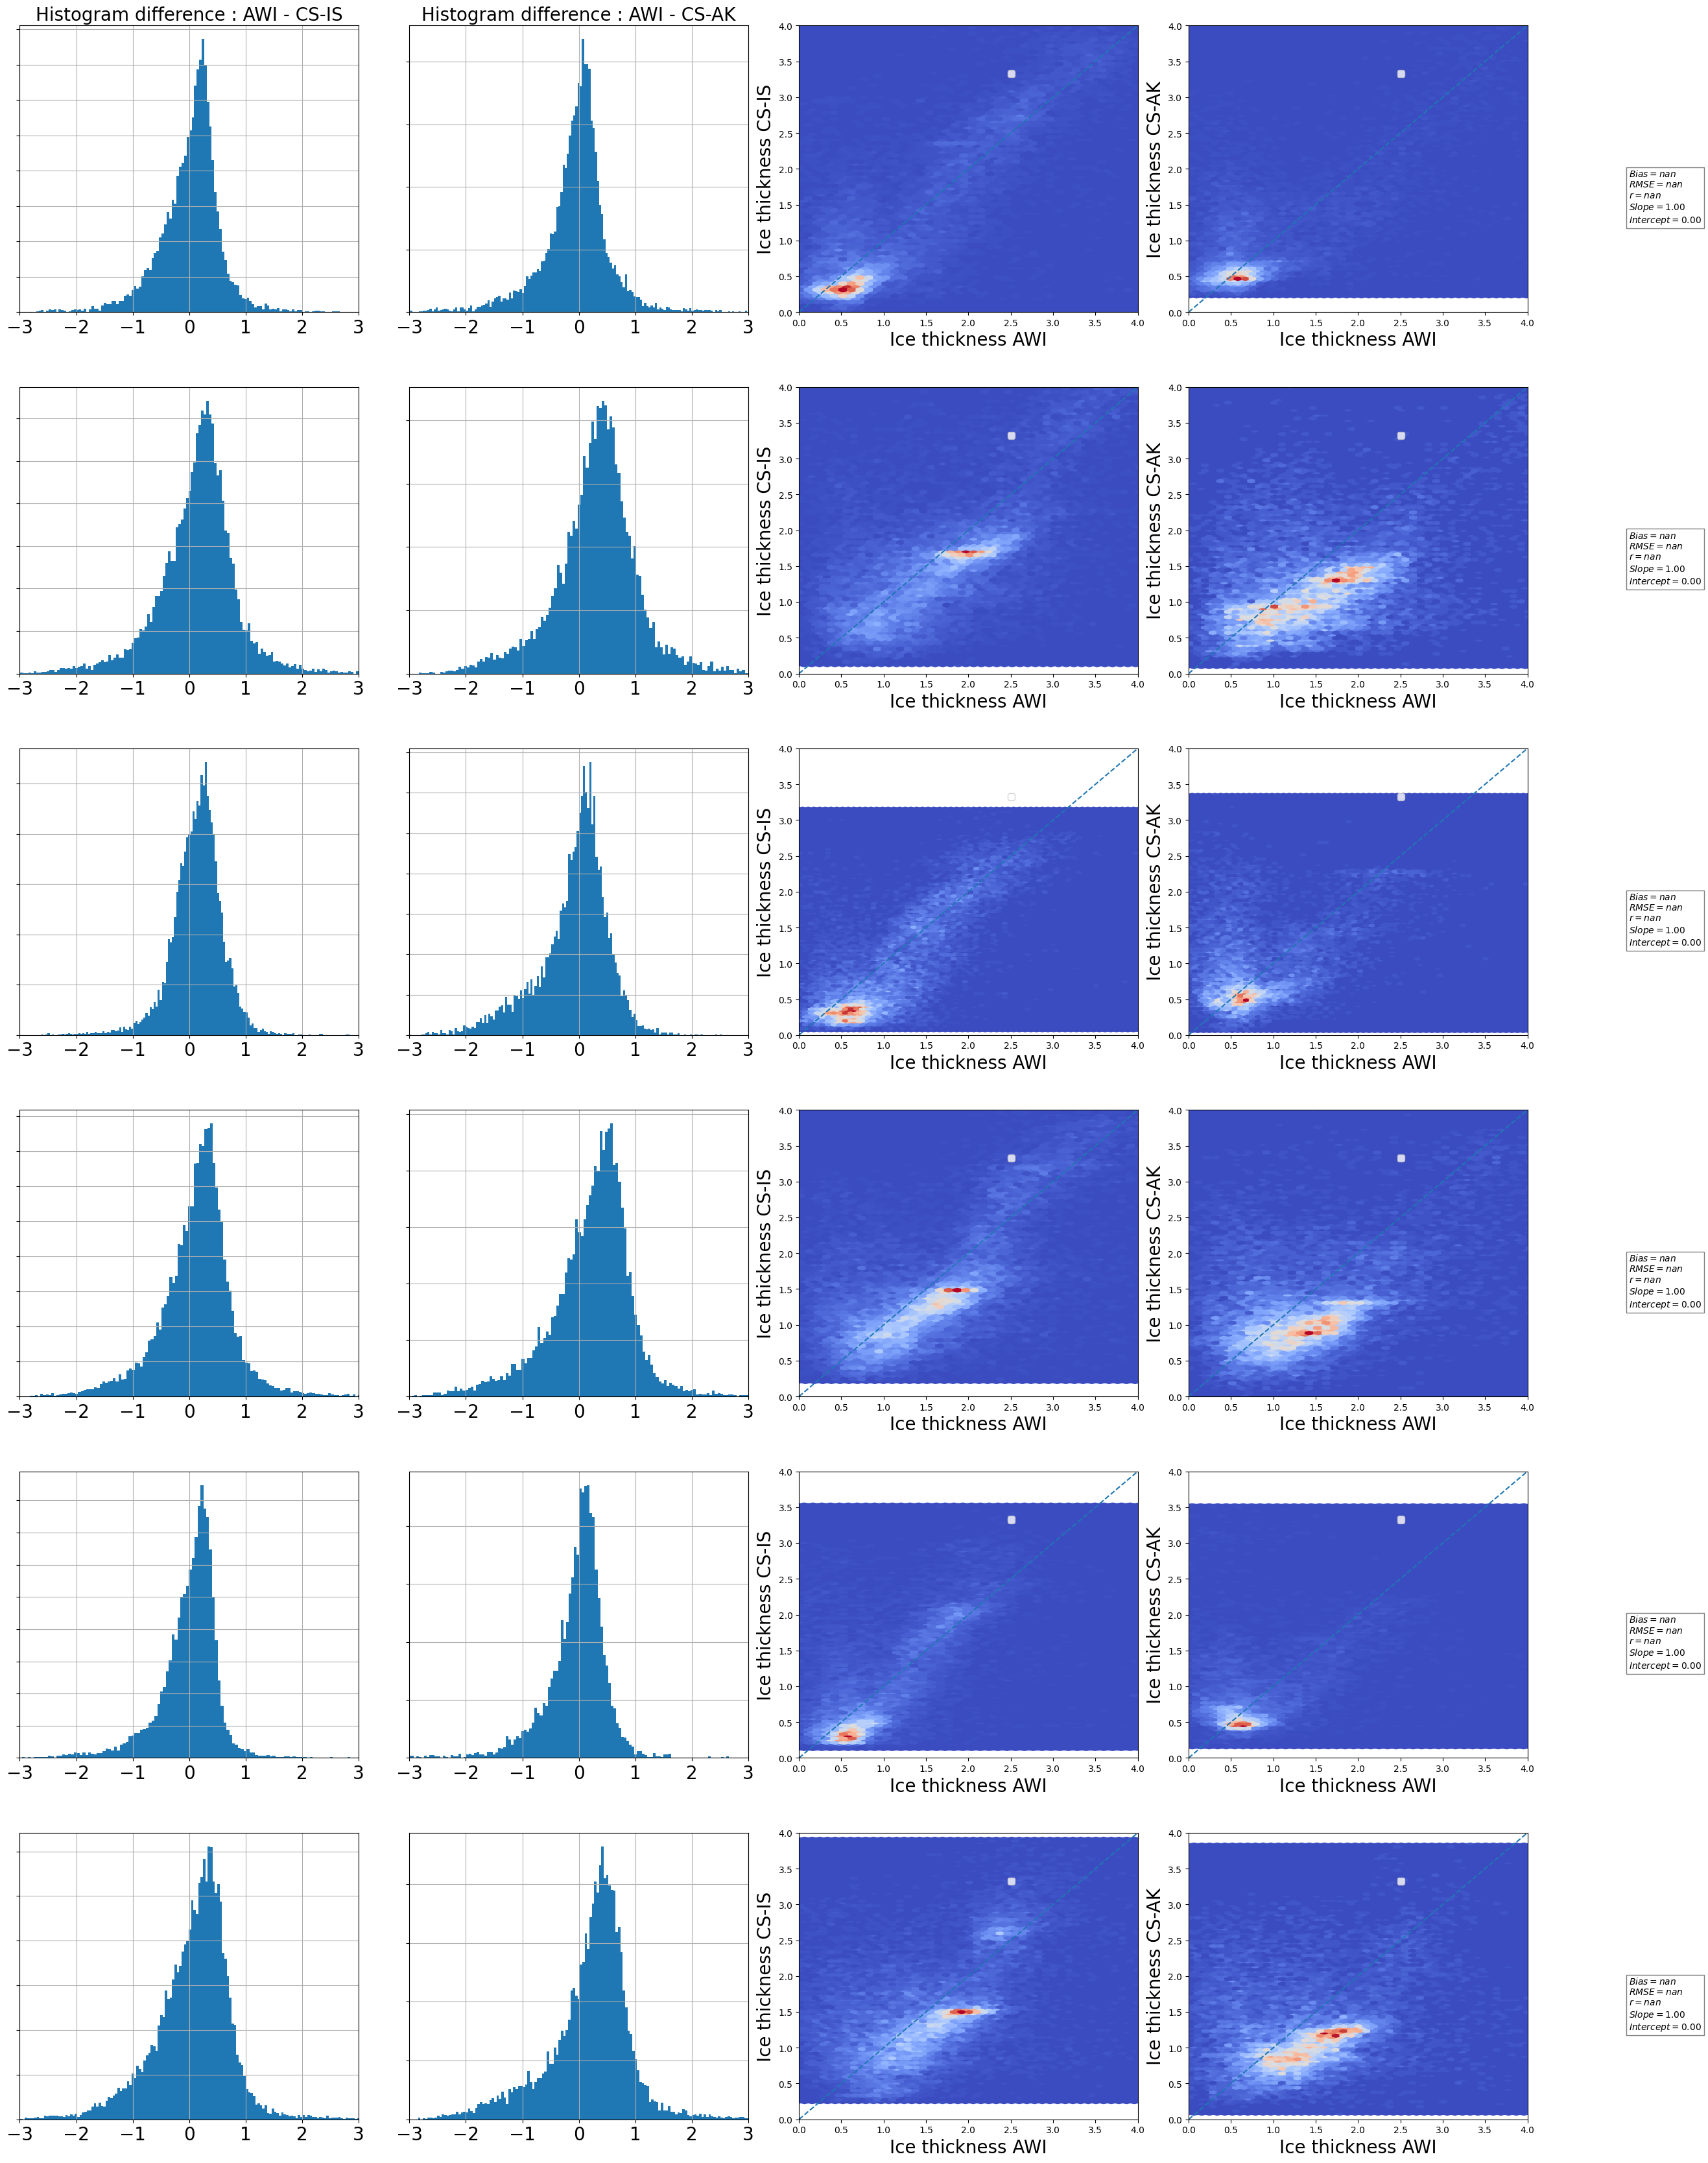

In [6]:
fig = plt.figure(figsize=(30,44))
spec = gridspec.GridSpec(ncols=4, nrows=7, hspace=0.3, wspace=0.15,height_ratios=[1,1,1, 1, 1,1, 0.1])

inverse_map_CSIS = [np.load(inverseCSIS20182019[0]), np.load(inverseCSIS20182019[5]), np.load(inverseCSIS20192020[0]), 
                    np.load(inverseCSIS20192020[5]), np.load(inverseCSIS20202021[0]), np.load(inverseCSIS20202021[5])]


inverse_map_CSAK = [np.load(inverseCSAK20182019[0]), np.load(inverseCSAK20182019[5]), np.load(inverseCSAK20192020[0]), 
                    np.load(inverseCSAK20192020[5]), np.load(inverseCSAK20202021[0]), np.load(inverseCSAK20202021[5])]

awi_map      = [awi_map_sit[0], awi_map_sit[5], awi_map_sit[6], awi_map_sit[11],
                    awi_map_sit[12], awi_map_sit[17]]

for i in range(6):
    ax1 = fig.add_subplot(spec[i, 0])
    if i == 0:
        ax1.set_title('Histogram difference : AWI - CS-IS', fontsize = 20)
    ice_inverse = []
    ice_awi = []
    for k in range(360):
        for j in range(360):
            ice_inverse.append(inverse_map_CSIS[i][k][j])
            ice_awi.append(awi_map[i][k][j])

    ice_inverse = np.array(ice_inverse)
    ice_awi = np.array(ice_awi)
    difference = ice_awi - ice_inverse
    ax1.hist(difference, bins = 250, histtype="stepfilled")
    ax1.set_xlim(-3, 3)
    ax1.yaxis.set_ticklabels([])
    ax1.tick_params(axis='x', labelsize=20)
    ax1.grid()

    ax2 = fig.add_subplot(spec[i, 1])
    if i == 0:
        ax2.set_title('Histogram difference : AWI - CS-AK', fontsize = 20)
    ice_inverse = []
    ice_awi = []
    for k in range(360):
        for j in range(360):
            ice_inverse.append(inverse_map_CSAK[i][k][j])
            ice_awi.append(awi_map[i][k][j])

    ice_inverse = np.array(ice_inverse)
    ice_awi = np.array(ice_awi)
    difference = ice_awi - ice_inverse
    ax2.hist(difference, bins = 250, histtype="stepfilled")
    ax2.set_xlim(-3, 3)
    ax2.yaxis.set_ticklabels([])
    ax2.tick_params(axis='x', labelsize=20)
    ax2.grid()

    ax3 = fig.add_subplot(spec[i, 2])
    if i == 0:
        ax3.set_title('', fontsize = 30)
    ice_inverse = []
    ice_awi = []
    for k in range(360):
        for j in range(360):
            ice_inverse.append(inverse_map_CSIS[i][k][j])
            ice_awi.append(awi_map[i][k][j])

    ice_inverse = np.array(ice_inverse)
    ice_awi = np.array(ice_awi)
    hb = ax3.hexbin(ice_awi, ice_inverse, bins = 250, cmap = 'coolwarm')
    ax3.set_xlim(0, 4)
    ax3.set_ylim(0, 4)
    ax3.set_xlabel('Ice thickness AWI', fontsize = 20)
    ax3.set_ylabel('Ice thickness CS-IS', fontsize = 20)

    md_snow_inverse, rmse_snow_inverse, r2_snow_inverse, slope, intercept = analyse(ice_awi, ice_inverse)
    r_snow = pearson(ice_inverse, ice_awi)

    textstr = '\n'.join((
        rf'$Bias={md_snow_inverse:.2f}$',
        rf'$RMSE={rmse_snow_inverse:.2f}$',
        rf'$r = {r_snow:.2f}$',
        rf'$Slope = {slope:.2f}$',
        rf'$Intercept = {intercept:.2f}$'))
    box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
    ax3.text(5.2, 2, textstr, bbox=box_props, verticalalignment='top')

    # Regression line
    x_values = np.array([0,6])
    y_values = slope * x_values + intercept
    ax3.plot(x_values, y_values, '--')
    ax3.legend(loc = "upper right",bbox_to_anchor=(0.65, 0.86))


    ax4 = fig.add_subplot(spec[i, 3])
    if i == 0:
        ax4.set_title('', fontsize = 30)
    ice_inverse = []
    ice_awi = []
    for k in range(360):
        for j in range(360):
            ice_inverse.append(inverse_map_CSAK[i][k][j])
            ice_awi.append(awi_map[i][k][j])

    ice_inverse = np.array(ice_inverse)
    ice_awi = np.array(ice_awi)
    hb = ax4.hexbin(ice_awi, ice_inverse, bins = 250, cmap = 'coolwarm')
    ax4.set_xlim(0, 4)
    ax4.set_ylim(0, 4)
    ax4.set_xlabel('Ice thickness AWI', fontsize = 20)
    ax4.set_ylabel('Ice thickness CS-AK', fontsize = 20)

    md_snow_inverse, rmse_snow_inverse, r2_snow_inverse, slope, intercept = analyse(ice_awi, ice_inverse)
    r_snow = pearson(ice_inverse, ice_awi)

    textstr = '\n'.join((
        rf'$Bias={md_snow_inverse:.2f}$',
        rf'$RMSE={rmse_snow_inverse:.2f}$',
        rf'$r = {r_snow:.2f}$',
        rf'$Slope = {slope:.2f}$',
        rf'$Intercept = {intercept:.2f}$'))
    box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
    ax4.text(5.2, 2, textstr, bbox=box_props, verticalalignment='top')

    # Regression line
    x_values = np.array([0,6])
    y_values = slope * x_values + intercept
    ax4.plot(x_values, y_values, '--')
    ax4.legend(loc = "upper right",bbox_to_anchor=(0.65, 0.86))



## Validation for CS-IS-3p and CS-IS-4p

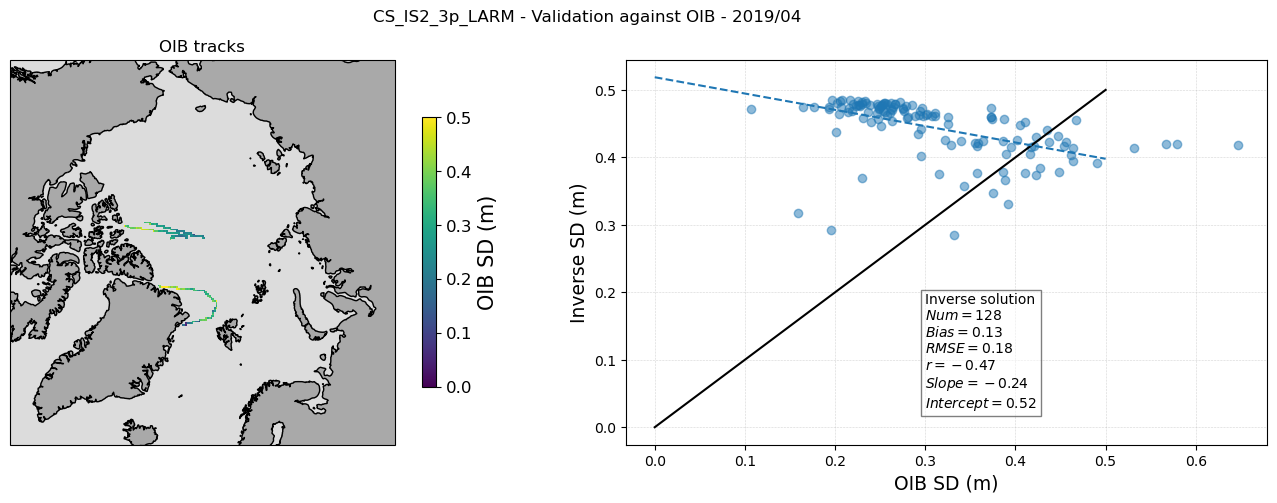

In [15]:
def ice_OIB(OIB_files):

    SIT_OIB = nc.Dataset(OIB_files).variables['Snow Depth'][:,:]
    return SIT_OIB

## Validation against OIB

OIB_files = ["/home/erb/masterproject/MSCI_project/validation_data/OIB_data/OIB_201904/20190408.nc",
             "/home/erb/masterproject/MSCI_project/validation_data/OIB_data/OIB_201904/20190412.nc",
             "/home/erb/masterproject/MSCI_project/validation_data/OIB_data/OIB_201904/20190419.nc",
             "/home/erb/masterproject/MSCI_project/validation_data/OIB_data/OIB_201904/20190420.nc",
             "/home/erb/masterproject/MSCI_project/validation_data/OIB_data/OIB_201904/20190422.nc"]

lon_g = np.load("/home/erb/masterproject/MSCI_project/new_lon_25km.npy")
lat_g = np.load("/home/erb/masterproject/MSCI_project/new_lat_25km.npy")

sie_path = '/home/erb/masterproject/MSCI_project/snow_ice/carmen/SIE/SIE_masking_25km_2018-2019_season.pkl'
f = open(sie_path,'rb')
sie_file = pickle.load(f)
sie_map  = sie_file['20190415']

OIB_array = []
for i in range(len(OIB_files)):
    OIB_array.append(nc.Dataset(OIB_files[i]).variables['Snow Depth'][:,:])

SD_OIB, SD_OIB_2 = [], []
snow_inverse = []


for i in range(len(OIB_files)):
    
    file_OIB = ice_OIB(OIB_files[i])
    inverse_snow_data = np.load('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/results_npy/non_interpolated_input/201904/15IS2-v6tesselationDelaunay_initcell1500_iteration1500000_proposal0.8_window15j_prioruniform-0.5-1.5_densitymixte_alphacs2_hierarchicalno_snow.npy')
    inverse_snow_stddev = np.load('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/results_npy/non_interpolated_input/201904/15IS2-v6tesselationDelaunay_initcell1500_iteration1500000_proposal0.8_window15j_prioruniform-0.5-1.5_densitymixte_alphacs2_hierarchicalno_snow_stddev.npy')

    inverse_snow_data = mask_high_error(inverse_snow_stddev, inverse_snow_data)
    inverse_snow_data = mask_sie(sie_map, inverse_snow_data)

    for k in range(360):
        for j in range(360):
            if not (file_OIB.mask[k][j]) and not np.isnan(inverse_snow_data[k][j]):
                snow_inverse.append(inverse_snow_data[k][j])
                SD_OIB.append(file_OIB[k][j])

fig = plt.figure(figsize = (17,5))
spec = gridspec.GridSpec(ncols=2, nrows=1,wspace=0.2, height_ratios=[1], width_ratios=[1.3, 1.5])

plt.rcParams['text.usetex'] = False
plt.suptitle('CS_IS2_3p_LARM - Validation against OIB - 2019/04')



ax1 = fig.add_subplot(spec[0], projection=ccrs.NorthPolarStereo())
ax1.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=0)
ax1.add_feature(cartopy.feature.OCEAN, color='gainsboro', edgecolor='black')
ax1.coastlines()
ax1.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
p_map = ax1.pcolormesh(lon_g,lat_g, OIB_array[0],cmap='viridis',alpha=1.0, transform=ccrs.PlateCarree(), vmin = 0, vmax = 0.5)
p_map = ax1.pcolormesh(lon_g,lat_g, OIB_array[1],cmap='viridis',alpha=1.0, transform=ccrs.PlateCarree(), vmin = 0, vmax = 0.5)
p_map = ax1.pcolormesh(lon_g,lat_g, OIB_array[2],cmap='viridis',alpha=1.0, transform=ccrs.PlateCarree(), vmin = 0, vmax = 0.5)
p_map = ax1.pcolormesh(lon_g,lat_g, OIB_array[3],cmap='viridis',alpha=1.0, transform=ccrs.PlateCarree(), vmin = 0, vmax = 0.5)
p_map = ax1.pcolormesh(lon_g,lat_g, OIB_array[4],cmap='viridis',alpha=1.0, transform=ccrs.PlateCarree(), vmin = 0, vmax = 0.5)
plt.title('OIB tracks')
a = fig.colorbar(p_map,shrink=0.7, pad=0.05, orientation = 'vertical')
a.ax.tick_params(labelsize=12)
a.set_label('OIB SD (m)',fontsize=15)


ax2 = fig.add_subplot(spec[1])
ax2.scatter(SD_OIB, snow_inverse, alpha = 0.5)
ax2.plot([0,0.5] , [0,0.5], 'k-')
ax2.grid(linestyle='dotted', linewidth ='0.4')
ax2.set_xlabel('OIB SD (m)', fontsize = 13.5)
ax2.set_ylabel('Inverse SD (m)', fontsize = 13.5)

md_snow_inverse, rmse_snow_inverse, r2_snow_inverse, slope, intercept = analyse(snow_inverse, SD_OIB)
r_snow = pearson(SD_OIB, snow_inverse)

textstr = '\n'.join((
    rf'Inverse solution',
    rf'$Num = {len(snow_inverse)}$',
    rf'$Bias={md_snow_inverse:.2f}$',
    rf'$RMSE={rmse_snow_inverse:.2f}$',
    rf'$r = {r_snow:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
ax2.text(0.3, 0.2, textstr, bbox=box_props, verticalalignment='top')

x_values = np.array([0,0.5])
y_values = slope * x_values + intercept
plt.plot(x_values, y_values, '--')



#fig.legend(loc = "upper right",bbox_to_anchor=(0.65, 0.86))

save_fig = 0
if save_fig == 1 :
    plt.savefig('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/validation/validation_OIB04-2019_snow_csis3p.png', dpi = 300)


## Comparison with MOSAiC and IceBird products

In [2]:
def filter_data(oib_file, oib_snow, snow_file, snow, lon, lat, is2_file, cs_file, Hi_data, Hs_data):
    ''' filters out the data that is available in both OIB and inversion files'''
    #loading OIB data
    #OIB = nc.Dataset('/home/erb/masterproject/MSCI_project/OIB/25km_ease_binned_data/20190415.nc')
    OIB  = nc.Dataset(oib_file)
    SD   = OIB.variables['Snow Depth'][:,:]
    long = OIB.variables['Longitude'][:,:]
    lati = OIB.variables['Latitude'][:,:]

    # loading inversion and freeboard data
    is2 = np.load(is2_file)
    cs  = np.load(cs_file)
    inverse_snow = np.load(snow_file)
    inverse_snow = mask_observations(is2, inverse_snow) # mask the observations to actual Altika tracks

    # forward linear regression
    DENSITY_WATER = 997.0
    DENSITY_ICE = 917.0
    DENSITY_SNOW = 300.0
    SPEED_OF_LIGHT_VACUUM_OVER_SPEED_OF_LIGHT_SNOW = 1.28

    A = (DENSITY_WATER - DENSITY_ICE) / DENSITY_WATER
    B = 1 - SPEED_OF_LIGHT_VACUUM_OVER_SPEED_OF_LIGHT_SNOW -DENSITY_SNOW/DENSITY_WATER
    D = 1 - DENSITY_SNOW/DENSITY_WATER

    Hi = (D*cs - B*is2)/ A*(D-B)
    Hs = (cs - is2) / (B -D)


    for i in range(360):
        for j in range(360):
            if not (SD.mask[i][j]) and not np.isnan(inverse_snow[i][j]):
                    #print(SD.data[i][j])
                oib_snow.append(SD.data[i][j])
                snow.append(inverse_snow[i][j])
                lon.append(long.data[i][j])
                lat.append(lati.data[i][j])
                Hi_data.append(Hi[i][j])
                Hs_data.append(Hs[i][j])

    OIB.close() 

In [8]:
import os

def extract_dates(folder_path):
    date = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.npy_snow') and not filename.endswith('.npy_ice_stddev'):
            info = filename.split('_')[4].split('.')[0] #split by '_' and remove .npy
            date.append(info)
    date.sort()
    return date

def extract_files(folder_path, dates, type):
    matching_files = []
    for date in dates:
        year = int(date[:4])  # Extract the year from the date
        initial_year = f"{year-1}-{year}"
        filename = f"FB_interp_{initial_year}_25km_{date}{type}"
        #filename = f"tesselationVoronoi_initcell10_iteration100000_date{date}{type}"
        file_path = os.path.join(folder_path, filename)
        #if os.path.exists(file_path):
        matching_files.append(file_path)
    return matching_files

def extract_IS2_files(folder_path, dates, type):
    matching_files = []
    for date in dates:
        year = int(date[:4])  # Extract the year from the date
        filename = f"FB_interp_{year}_25km_{date}{type}"
        #filename = f"tesselationVoronoi_initcell10_iteration100000_date{date}{type}"
        file_path = os.path.join(folder_path, filename)
        #if os.path.exists(file_path):
        matching_files.append(file_path)
    return matching_files

def extract_snow_files(folder_path, dates, type):
    matching_files = []
    for date in dates:
        year = int(date[:4])  # Extract the year from the date
        #filename = f"FB_interp_{year}_25km_{date}{type}"
        #filename = f"tesselationDelaunay_initcell1000_iteration700000_date{date}_window+4j_snow{type}"
        filename = '15IS2v6-tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs21_hierarchicalno_errorproduct_snow'
        file_path = os.path.join(folder_path, str(year), '/', filename)
        #if os.path.exists(file_path):
        print(file_path)
        matching_files.append(file_path)
    return matching_files

def extract_OIB(folder_path, dates):
    files = []
    for date in dates:
        filename = f'{date}.nc'
        file_path = os.path.join(folder_path, filename)

        #if os.path.exists(file_path):
        files.append(file_path)

    return files

import os


def extract_files(folder_path, dates, type):
    matching_files = []
    for date in dates:
        year = int(date[:4])  # Extract the year from the date
        initial_year = f"{2019}-{2020}"
        filename = f"FB_interp_{initial_year}_25km_{date}{type}"
        file_path = os.path.join(folder_path, filename)
        #if os.path.exists(file_path):
        matching_files.append(file_path)
    return matching_files

def mask_observations(observations, inversion):
    new_inversion = np.copy(inversion)
    for i in range(len(observations)):
        for j in range(len(observations[0])):
            if np.isnan(observations[i][j]):
                new_inversion[i][j] = np.nan
    return new_inversion


In [9]:
# MOSAIC Validation data (Winter 2019 - 2020)

date = ['20191115', '20191215', '20200115', '20200215', '20200315', '20200415']

snow_files = ['/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201911/15IS2v6-tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs21_hierarchicalno_errorproduct_snow.npy',
'/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201912/15IS2v6-tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs21_hierarchicalno_errorproduct_snow.npy',
'/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202001/15IS2v6-tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs21_hierarchicalno_errorproduct_snow.npy',
'/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202002/15IS2v6-tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs21_hierarchicalno_errorproduct_snow.npy',
'/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202003/15IS2v6-tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs21_hierarchicalno_errorproduct_snow.npy',
'/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202004/15IS2v6-tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs21_hierarchicalno_errorproduct_snow.npy']
MOSAIC_files = extract_OIB('/home/erb/masterproject/MSCI_project/validation_data/various_data/UIT_MOSAIC', date)

is2_files = extract_IS2_files('/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/IS2/', date,'.npy')
cs_files = extract_files('/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/CS2_LARM/', date, '.npy')

# Initialize arrays to store filtered data
MOSAIC_snow = []
lon_data = []
lat_data = []
snow_data = []
Hi_data = []
Hs_data = []

for i in range(len(date)):
    filter_data(MOSAIC_files[i], MOSAIC_snow, snow_files[i], snow_data, lon_data, lat_data, is2_files[i], cs_files[i], Hi_data, Hs_data)

In [18]:
import os

def extract_snow_files(folder_path, dates, type):
    matching_files = []
    for date in dates:
        year = int(date[:4])  # Extract the year from the date
        #filename = f"FB_interp_{year}_25km_{date}{type}"
        filename = f"tesselationDelaunay_initcell1000_iteration700000_date{date}_window+-2j_error0.01_snow{type}"
        file_path = os.path.join(folder_path, filename)
        #if os.path.exists(file_path):
        matching_files.append(file_path)
    return matching_files

def extract_files(folder_path, dates, type):
    matching_files = []
    for date in dates:
        year = int(date[:4])  # Extract the year from the date
        initial_year = f"{2018}-{2019}"
        filename = f"FB_interp_{initial_year}_25km_{date}{type}"
        file_path = os.path.join(folder_path, filename)
        #if os.path.exists(file_path):
        matching_files.append(file_path)
    return matching_files

date = ['20190415']

#snow_files = extract_snow_files('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/', date, '.npy')
snow_files_201904 = ['/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201904/15IS2v6-tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs21_hierarchicalno_errorproduct_snow.npy']
IB_files = extract_OIB('/home/erb/masterproject/MSCI_project/validation_data/various_data/UIT_IB', date)
is2_files = extract_IS2_files('/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/IS2/', date,'.npy')
cs_files = extract_files('/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/CS2_LARM/', date, '.npy')

IB_snow = []
lon_data = []
lat_data = []
snow_data_201904 = []
Hi_data = []
Hs_data = []

for i in range(len(date)):
    filter_data(IB_files[i], IB_snow, snow_files_201904[i], snow_data_201904, lon_data, lat_data, is2_files[i], cs_files[i], Hi_data, Hs_data)

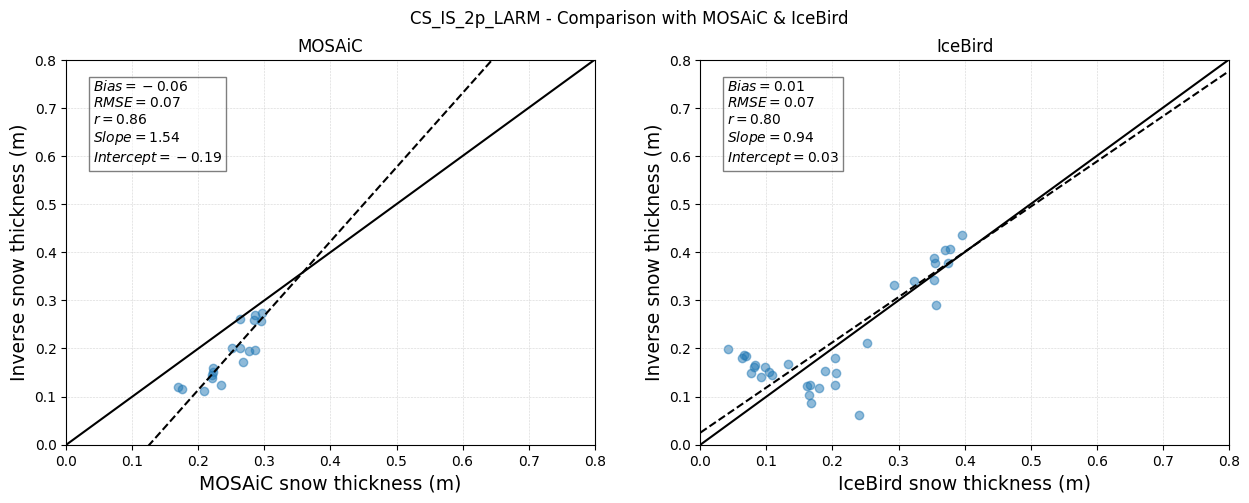

In [24]:
fig = plt.figure(figsize=(15, 5))
spec = gridspec.GridSpec(ncols=2, nrows=1,wspace=0.2, height_ratios=[1], width_ratios=[1.3, 1.3])


plt.suptitle('CS_IS_2p_LARM - Comparison with MOSAiC & IceBird')
#ax = fig.add_subplot(121)
ax = fig.add_subplot(spec[0])
ax.scatter(MOSAIC_snow, snow_data, alpha = 0.5)
ax.plot([0,0.8] , [0,0.8], 'k-')
ax.grid(linestyle='dotted', linewidth ='0.4')
ax.set_xlabel('MOSAiC snow thickness (m)', fontsize = 13.5)
ax.set_ylabel('Inverse snow thickness (m)', fontsize = 13.5)
ax.set_title("MOSAiC")
ax.set_xlim(0, 0.8)
ax.set_ylim(0, 0.8)

md_snow_inverse, rmse_snow_inverse, r2_snow_inverse, slope, intercept = analyse(snow_data, MOSAIC_snow)
r_snow = pearson(MOSAIC_snow, snow_data)

textstr = '\n'.join((
    rf'$Bias={md_snow_inverse:.2f}$',
    rf'$RMSE={rmse_snow_inverse:.2f}$',
    #rf'$R^2={r2_snow_inverse:.2f}$',
    rf'$r = {r_snow:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=box_props)

# Regression line
x_values = np.array([0,0.8])
y_values = slope * x_values + intercept
plt.plot(x_values, y_values, 'k--')


ax2 = fig.add_subplot(spec[1])
ax2.scatter(IB_snow, snow_data_201904, alpha = 0.5)
ax2.plot([0,0.8] , [0,0.8], 'k-')
ax2.grid(linestyle='dotted', linewidth ='0.4')
ax2.set_xlabel('IceBird snow thickness (m)', fontsize = 13.5)
ax2.set_ylabel('Inverse snow thickness (m)', fontsize = 13.5)
ax2.set_xlim(0, 0.8)
ax2.set_ylim(0, 0.8)
ax2.set_title("IceBird")

md_snow_inverse, rmse_snow_inverse, r2_snow_inverse, slope, intercept = analyse(snow_data_201904, IB_snow)
r_snow = pearson(IB_snow, snow_data_201904)

textstr = '\n'.join((
    rf'$Bias={md_snow_inverse:.2f}$',
    rf'$RMSE={rmse_snow_inverse:.2f}$',
    #rf'$R^2={r2_snow_inverse:.2f}$',
    rf'$r = {r_snow:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=box_props)

# Regression line
x_values = np.array([0,0.8])
y_values = slope * x_values + intercept
plt.plot(x_values, y_values, 'k--')




save_fig = 1
if save_fig == 1 :
    plt.savefig('/home/erb/masterproject/MSCI_project/snow_ice/figures_paper/figures/validation_MOSAiC&IceBird.png', dpi = 300)
